# SPATIAL ANALYSIS OF ISS DATASETS

This tutorial is an example of how to use Squidpy to analyze In Situ Sequencing datasets, performing several different statistical tests to understand the spatial organization of tissues. This tutorial follows the scanpy tutorial/pciseq tutorials, so we'll take as an input an h5 object created. More information, if needed, can be found at: https://squidpy.readthedocs.io/en/stable/tutorials.html

# Loading the needed packages

The first step is to load the needed packages. If any of them fails, please go and check that they are installed in the appropiate environment

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st
import squidpy as sq
import scanpy as sc
import os
def map_of_clusters(adata,key='leiden',clusters='all',size=8,background='white',figuresize=(10,7),save=None,format='pdf'):
    
    #PARAMETERS TO MODIFY:
    #-key: the terms in adata.obs that you want to plot
    #-clusters:'all' for plotting all clusters in a single plot, 'individual': for plots of individual genes, or ['3','5'] (your groups
    #          between square brackets to plot only some clusters
    #-size: to change the size of your spots
    #-background: to change the color of the background
    #-figuresize: to specify the size of your figure
    #-save: if you want to save your figure, give the PATH of the folder where you want to save it
    #-format: specify the format in which you want to save your figure
    
    try:
        adata.obs[key]=adata.obs[key].astype(int)
        colors=dict(zip(np.unique(adata.obs[key]),adata.uns[key+'_colors']))
    except:
        colors=dict(zip(np.unique(adata.obs[key]),adata.uns[key+'_colors']))
    #cl.apply(lambda x: colors[x])
    plt.rcParams['figure.facecolor'] = background
    if clusters=='all':
        cl=adata.obs[key]
        plt.figure(figsize=figuresize)
        figa=plt.scatter(x=adata.obs.X,y=adata.obs.Y,c=cl.apply(lambda x: colors[x]),s=size,linewidths=0, edgecolors=None)
        plt.axis('off')
        if not save==None:
            plt.savefig(save +'/map_all_clusters_'+str(size)+'_'+background+'_'+key+'.'+format)
    elif clusters=='individual':
        cl=adata.obs[key]
        for each in adata.obs[key].unique():
            adatasub=adata[adata.obs[key]==each]
            plt.figure(figsize=figuresize)
            plt.scatter(x=adata.obs.X,y=adata.obs.Y,c='grey',s=size/5,linewidths=0, edgecolors=None)
            cl=adatasub.obs[key]
            plt.scatter(x=adatasub.obs.X,y=adatasub.obs.Y,c=cl.apply(lambda x: colors[x]),s=size,linewidths=0, edgecolors=None)
            plt.axis('off')
            plt.title('Group: '+ str(each))
            if not save==None:
                plt.savefig(save +'/map_inidivdual_cluster_'+str(each)+'_'+str(size)+background+'_'+key+'.'+format)
    else:
        adatasub=adata[adata.obs[key].isin(clusters)]
        plt.figure(figsize=figuresize)
        plt.scatter(x=adata.obs.X,y=adata.obs.Y,c='grey',s=size/5,linewidths=0, edgecolors=None)
        cl=adatasub.obs[key]
        plt.scatter(x=adatasub.obs.X,y=adatasub.obs.Y,c=cl.apply(lambda x: colors[x]),s=size,linewidths=0, edgecolors=None)
        plt.axis('off')
        plt.legend()
        if not save==None:
                s=''
                for element in clusters:
                    s=s+str(element)
                print(s)
                plt.savefig(save +'/map_group_of_clusters_'+str(s)+'_'+str(size)+background+'_'+key+'.'+format)
#        plt.title('Group: '+ paste(clusters))

/opt/anaconda3/envs/sccellfie/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/opt/anaconda3/envs/sccellfie/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


# Load your dataset

We are going to load our dataset, were we have alredy performed clustering, from an h5ad file. If you want to check how to format your data in this format, please check the Scanpy tutorial

In [2]:
path='/mnt/f/COPD/final_data_COPD/'

In [3]:
path='/mnt/f/COPD/final_data_COPD/'
files=os.listdir(path)
alls=[]
for f in files[0:2]:
    print(f)
    tab=pd.read_excel(path+f)
    tab['donor_name']=f.split('-')[0]
    tab['reg']=f.split('-')[1]
    tab['sample_name']=tab['donor_name']+'_'+tab['reg']
    #tab.columns=[t.lower().replace(' ','') for t in tab.columns]
    tab=tab.reset_index()
    tab.columns=[t.lower().replace(' ','') for t in tab.columns]
   # tab.columns=refcol
  #  tab.columns[0]='old_index'
    print(tab.shape)
    alls.append(tab)

ATLAS-Integration-CT.xlsx
(303127, 19)
COPD-cell-types.xlsx
(84631, 20)


In [4]:
allcells=pd.concat(alls,axis=0)


In [5]:
di={'Smooth muscle':'Smooth Muscle','Epithelial other':'Epithelial unknown'}
allcells.loc[allcells['celltype']=='Smooth muscle','celltype']='Smooth Muscle'

In [6]:
allall=allcells

In [7]:
l2=['SMG Serous', 'SMG intermediate (duct)', 'Smooth muscle', 'Myoepithelial', 'SMG mucous', 'SMG serous']
allall2=allall#.loc[allall['celltype'].isin(common+l2),:]

In [8]:
adata=sc.AnnData(obs=allall2)

/home/sergioms/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/sergioms/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [9]:
adata.obsm["spatial"]=np.array([adata.obs.x,adata.obs.y,adata.obs.y]).transpose().astype('float64')

In [10]:
#adata.obs.to_csv('/mnt/c/Users/sergio.salas/Documents/PhD/projects/DIPG/UMPED65_A2_2_celltypes.csv')

In [11]:
adata

AnnData object with n_obs × n_vars = 387758 × 0
    obs: 'index', 'region', 'sample', 'donor', 'condition', 'smoking', 'gender', 'cell', 'roi', 'x', 'y', 'area', 'clusters-pc7', 'cellclass', 'celltype', 'cellsubtype', 'donor_name', 'reg', 'sample_name', 'image'
    obsm: 'spatial'

In [ ]:
for samp in adata.obs['sample'].unique():
    asub=adata[adata.obs['sample']==samp]
    print(samp)
    plt.figure(figsize=(50,50))
    sc.pl.spatial(
    asub,
    color="celltype",
    neighbors_key="spatial_neighbors",
    spot_size=70,
    edges=False,
    edges_width=2,
    img_key=None,
    )

# NEIGHBORHOOD PLOTS

In [12]:
adata.obs['name']=adata.obs['celltype']
ad=adata

In [13]:
ctps_atlas=ad.obs.loc[ad.obs['donor_name']!='COPD','celltype'].unique()
ctps_biopsies=ad.obs.loc[ad.obs['donor_name']=='COPD','celltype'].unique()
selcts=[e for e in ctps_atlas if e in ctps_biopsies]
allselected=selcts+['SMG Serous', 'SMG intermediate (duct)', 'Smooth muscle', 'Myoepithelial', 'SMG mucous', 'SMG serous']

In [14]:
ad=ad[ad.obs['celltype'].isin(allselected)]

In [15]:
anndata_list = []
for sample in ad.obs['sample'].unique():
    adata_copy_int = ad[ad.obs['sample'] == sample ]
    #    adata_copy_int.obs.index = list(pd.DataFrame(list((adata_copy_int.obs['sample'])))[0] +'_' +pd.DataFrame(list((adata_copy_int.obs.index)))[0])
    sq.gr.spatial_neighbors(adata_copy_int,n_neighs=20)
    result=np.zeros([adata_copy_int.shape[0],len(adata_copy_int.obs['name'].unique())])
    n=0
    tr=adata_copy_int.obsp['spatial_distances'].transpose()
    tr2=tr>0
    from tqdm import tqdm
    for g in tqdm(adata_copy_int.obs['name'].unique()):
        epv=adata_copy_int.obs['name']==g*1
        opv=list(epv*1)
        result[:,n]=tr2.dot(opv)
        n=n+1
    expmat=pd.DataFrame(result,columns=adata_copy_int.obs['name'].unique())
    adata1=sc.AnnData(expmat,obs=adata_copy_int.obs)
    adata1.obs['sample']=sample
    adata1.obs['total_counts']=list(np.sum(expmat,axis=1))
    anndata_list.append(adata1)
ad_sp_concat = sc.concat(anndata_list, pairwise=True,join='outer')

/home/sergioms/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/sergioms/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 694.63it/s]
/tmp/ipykernel_48/486743544.py:17: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata1=sc.AnnData(expmat,obs=adata_copy_int.obs)
/home/sergioms/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming 

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 802.54it/s]
/tmp/ipykernel_48/486743544.py:17: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata1=sc.AnnData(expmat,obs=adata_copy_int.obs)
/home/sergioms/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/sergioms/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:00<00:00, 273.59it/s]
/

/home/sergioms/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/sergioms/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
100%|█████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 1318.24it/s]
/tmp/ipykernel_48/486743544.py:17: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata1=sc.AnnData(expmat,obs=adata_copy_int.obs)
/home/sergioms/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming 

In [16]:
'''
anndata_list = []
for sample in ad.obs['sample'].unique():
    adata_copy_int = ad[ad.obs['sample'] == sample ]
###    adata_copy_int.obs.index = list(pd.DataFrame(list((adata_copy_int.obs['sample'])))[0] +'_' +pd.DataFrame(list((adata_copy_int.obs.index)))[0])
    sq.gr.spatial_neighbors(adata_copy_int,radius=250.0,coord_type='generic')
    arrs=((adata_copy_int.obsp['spatial_distances']>0).toarray())*1
    datf=pd.DataFrame(arrs)
    datf['key']=list(adata_copy_int.obs['name'])
    neighmatrix=datf.groupby('key').sum().transpose()
    adataneigh=sc.AnnData(neighmatrix)
    adataneigh.obs=adata_copy_int.obs
    adataneigh.obs['counts']=list(np.sum(neighmatrix,axis=1))
    anndata_list.append(adataneigh)
ad_sp_concat = sc.concat(anndata_list, pairwise=True,join='outer')
'''

"\nanndata_list = []\nfor sample in ad.obs['sample'].unique():\n    adata_copy_int = ad[ad.obs['sample'] == sample ]\n###    adata_copy_int.obs.index = list(pd.DataFrame(list((adata_copy_int.obs['sample'])))[0] +'_' +pd.DataFrame(list((adata_copy_int.obs.index)))[0])\n    sq.gr.spatial_neighbors(adata_copy_int,radius=250.0,coord_type='generic')\n    arrs=((adata_copy_int.obsp['spatial_distances']>0).toarray())*1\n    datf=pd.DataFrame(arrs)\n    datf['key']=list(adata_copy_int.obs['name'])\n    neighmatrix=datf.groupby('key').sum().transpose()\n    adataneigh=sc.AnnData(neighmatrix)\n    adataneigh.obs=adata_copy_int.obs\n    adataneigh.obs['counts']=list(np.sum(neighmatrix,axis=1))\n    anndata_list.append(adataneigh)\nad_sp_concat = sc.concat(anndata_list, pairwise=True,join='outer')\n"

In [17]:
adataneigh=ad_sp_concat#[:,ad_sp_concat.var.index.isin(['MES_like','Cycling','OPC_like','AC_like','OC_like'])]
adataneigh.obsm["spatial"]=np.array([adataneigh.obs.x,adataneigh.obs.y]).transpose().astype('float64')
adataneigh.X=np.nan_to_num(adataneigh.X)
#adataneigh=adataneigh[adataneigh.obs['total_counts']>5]
#adataneigh=adataneigh[adataneigh.obs['counts']<80]

In [18]:
#adataneigh=adataneigh[:,adataneigh.var.index.isin(allselected)]

In [19]:
adataneigh

AnnData object with n_obs × n_vars = 296214 × 28
    obs: 'index', 'region', 'sample', 'donor', 'condition', 'smoking', 'gender', 'cell', 'roi', 'x', 'y', 'area', 'clusters-pc7', 'cellclass', 'celltype', 'cellsubtype', 'donor_name', 'reg', 'sample_name', 'image', 'name', 'total_counts'
    obsm: 'spatial'

In [20]:
sc.pp.filter_cells(adataneigh,min_genes=2)
sc.pp.filter_cells(adataneigh,min_counts=5)

/home/sergioms/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/sergioms/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [21]:
adataneigh.raw=adataneigh
#sc.pp.log1p(adataneigh)
#sc.pp.normalize_total(adataneigh, target_sum=1e4)


In [22]:
sc.pp.neighbors(adataneigh, n_neighbors=30)
#sc.tl.umap(adataneigh,min_dist=0.1)
sc.set_figure_params(scanpy=True, dpi=200)

/home/sergioms/.local/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/sergioms/.local/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/sergioms/.local/lib/python3.8/site-packages/umap/distances.py:1086: NumbaDeprecationWarning:

In [23]:
sc.tl.umap(adataneigh,min_dist=0.1,spread=1.2)

In [44]:
sc.tl.leiden(adataneigh,resolution=0.3,key_added='domains')

In [45]:
tab=adataneigh.obs.groupby('domains').count()
adataneigh=adataneigh[adataneigh.obs['domains'].isin(tab.loc[tab.loc[:,'cell']>50].index)]
adataneigh.var.index=adataneigh.var.index.astype(str)

/home/sergioms/.local/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/home/sergioms/.local/lib/python3.8/site-packages/anndata/_core/anndata.py:1828: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


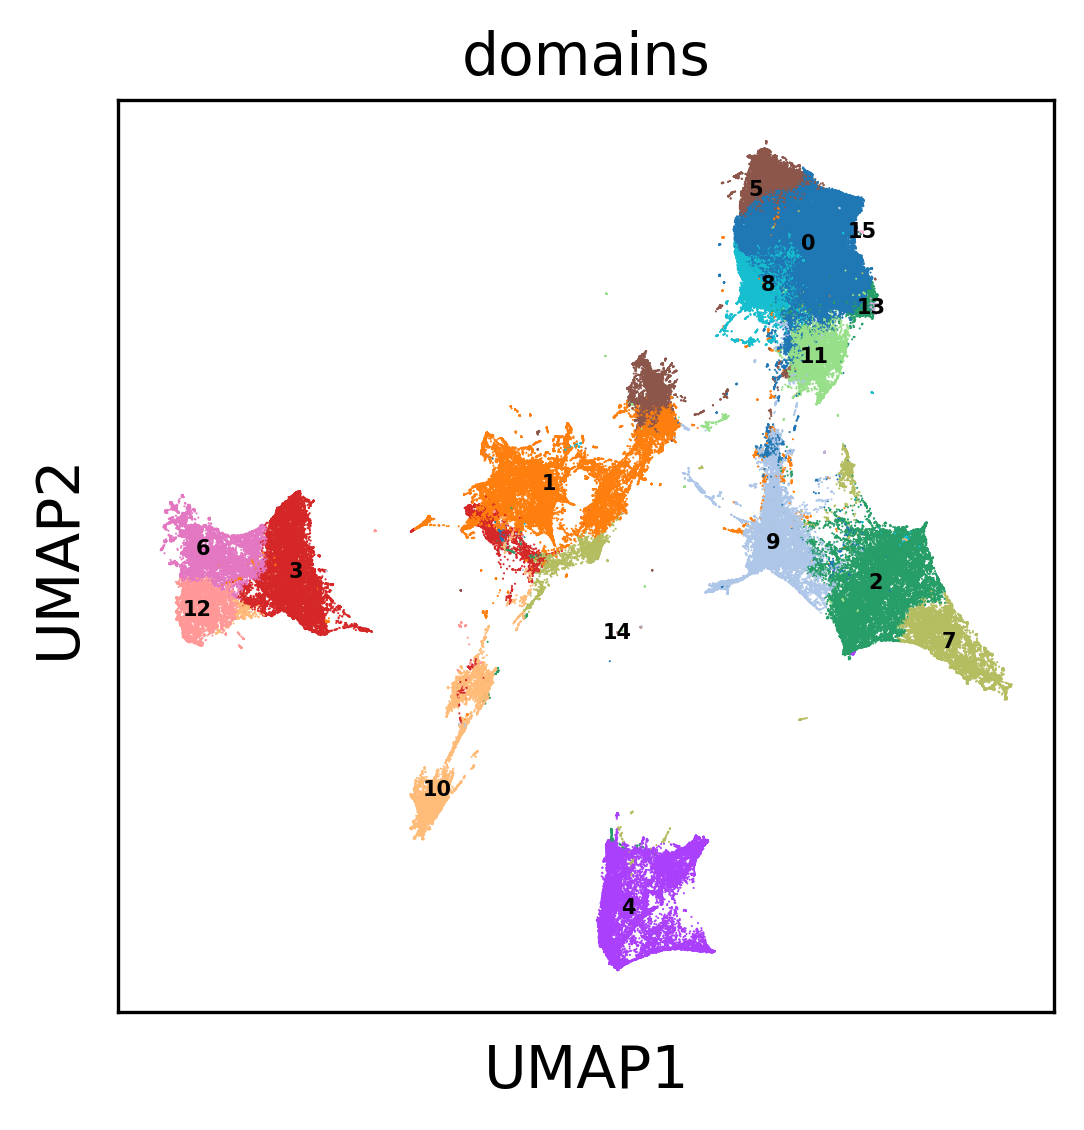

In [46]:
sc.set_figure_params(scanpy=True, dpi=150, dpi_save=150, frameon=True, vector_friendly=True, fontsize=14, figsize=None, color_map=None, format='pdf', facecolor='white', transparent=False, ipython_format='png2x')
sc.pl.umap(adataneigh,color=['domains'],s=1,ncols=1,legend_loc='on data',legend_fontsize=5)#,save='UMAP_10X_colors.svg')

In [47]:
adataneigh.uns['domains_colors'] = [
    "#FFD1DC",  # Pale Pink
    "#E6E6FA",  # Lavender
    "#89CFF0",  # Baby Blue
    "#98FB98",  # Mint Green
    "#FFE5B4",  # Peach
    "#FFFFE0",  # Light Yellow
    "#FFB347",  # Pastel Orange
    "#B0E0E6",  # Powder Blue
    "#DCD0FF",  # Light Lavender
    "#98FB98",  # Pale Green
    "#C8A2C8",  # Soft Lilac
    "#F08080",  # Coral Pink
    "#CCCCFF",  # Periwinkle
    "#AFEEEE",  # Light Turquoise
    "#FFFACD",  # Pale Lemon
    "#87CEEB",  # Pale Cyan
    "#F7CAC9",  # Rose Quartz
    "#DB7093",  # Pale Violet
    "#FFE5B4",  # Pale Apricot
    "#B0C4DE",   # Light Grayish Blue
    "#FFB6C1",  # Light Pink
    "#FFDEAD",  # Navajo White
    "#FFA07A",  # Light Salmon
    "#F0FFF0",  # Honeydew
    "#87CEEB"   # Sky Blue
]
adataneigh.uns['domains_colors'] = [
    "#7fc97f",  # Greenish
    "#beaed4",  # Pale Purple
    "#fdc086",  # Light Orange
    "#ffff99",  # Light Yellow
    "#386cb0",  # Dark Blue
    "#f0027f",  # Pinkish
    "#bf5b17",  # Dark Brown
    "#666666",  # Dark Gray
    "#1b9e77",  # Medium Green
    "#fdae6b",  # Light Orange
    "#b2df8a",  # Light Green
    "#33a02c",  # Dark Green
    "#fb9a99",  # Pink
    "#e31a1c",  # Red
    "#fdbf6f",  # Medium Orange
    "#ff7f00",  # Dark Orange
    "#cab2d6",  # Light Purple
    "#6a3d9a",  # Dark Purple
    "#b15928",  # Dark Orange
    "#e7298a",  # Magenta
    "#66a61e",  # Olive Green
    "#d95f02",  # Dark Orange
    "#7570b3",  # Purple
    "#e6ab02",  # Yellow Orange
    "#a6761d"   # Dark Yellow
]


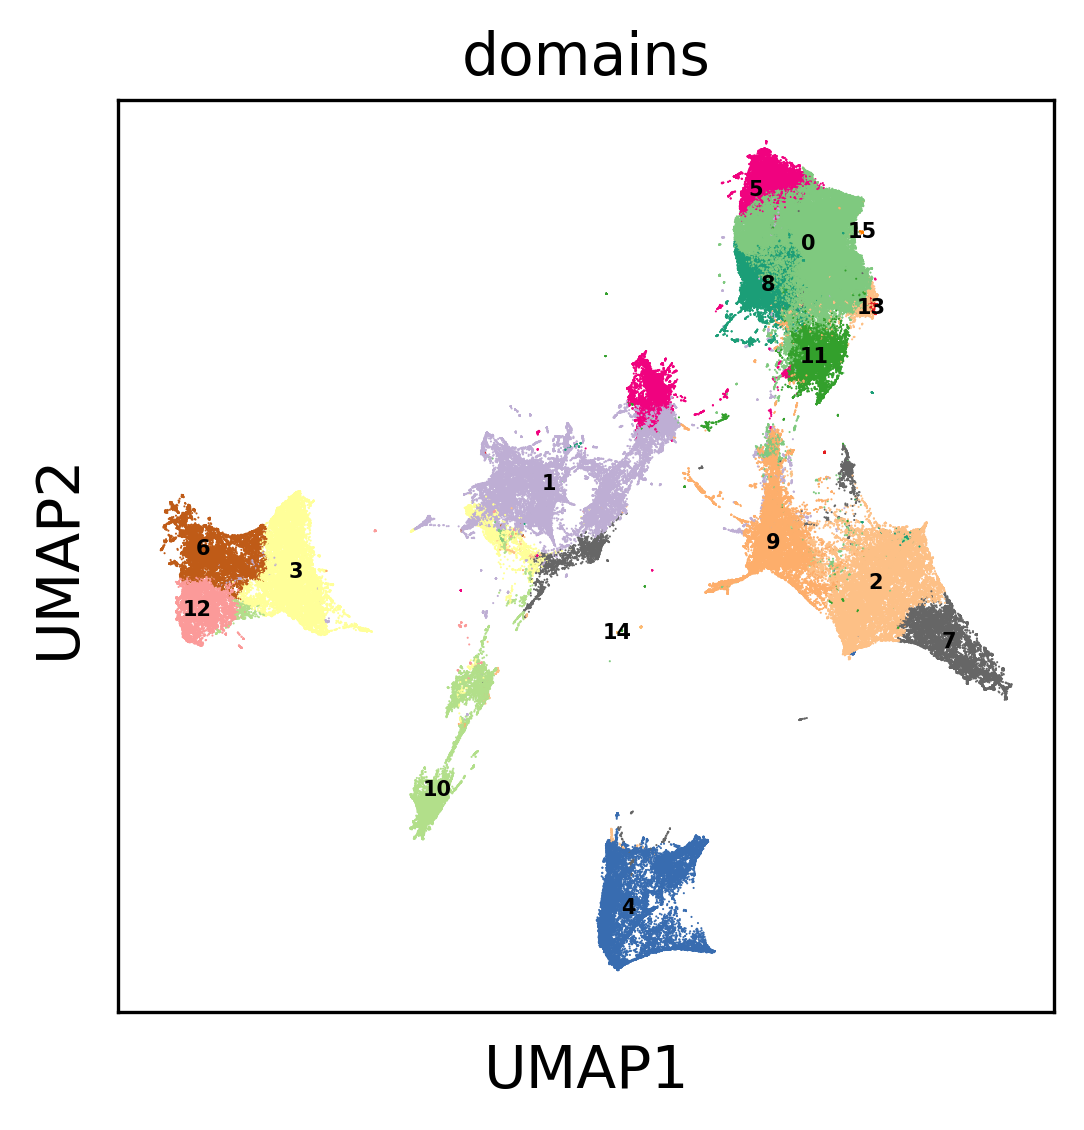

In [3]:
sc.set_figure_params(scanpy=True, dpi=150, dpi_save=150, frameon=True, vector_friendly=True, fontsize=14, figsize=None, color_map=None, format='pdf', facecolor='white', transparent=False, ipython_format='png2x')
sc.pl.umap(adataneigh,color=['domains'],s=1,ncols=1,legend_loc='on data',legend_fontsize=5)#,save='UMAP_10X_colors.svg')

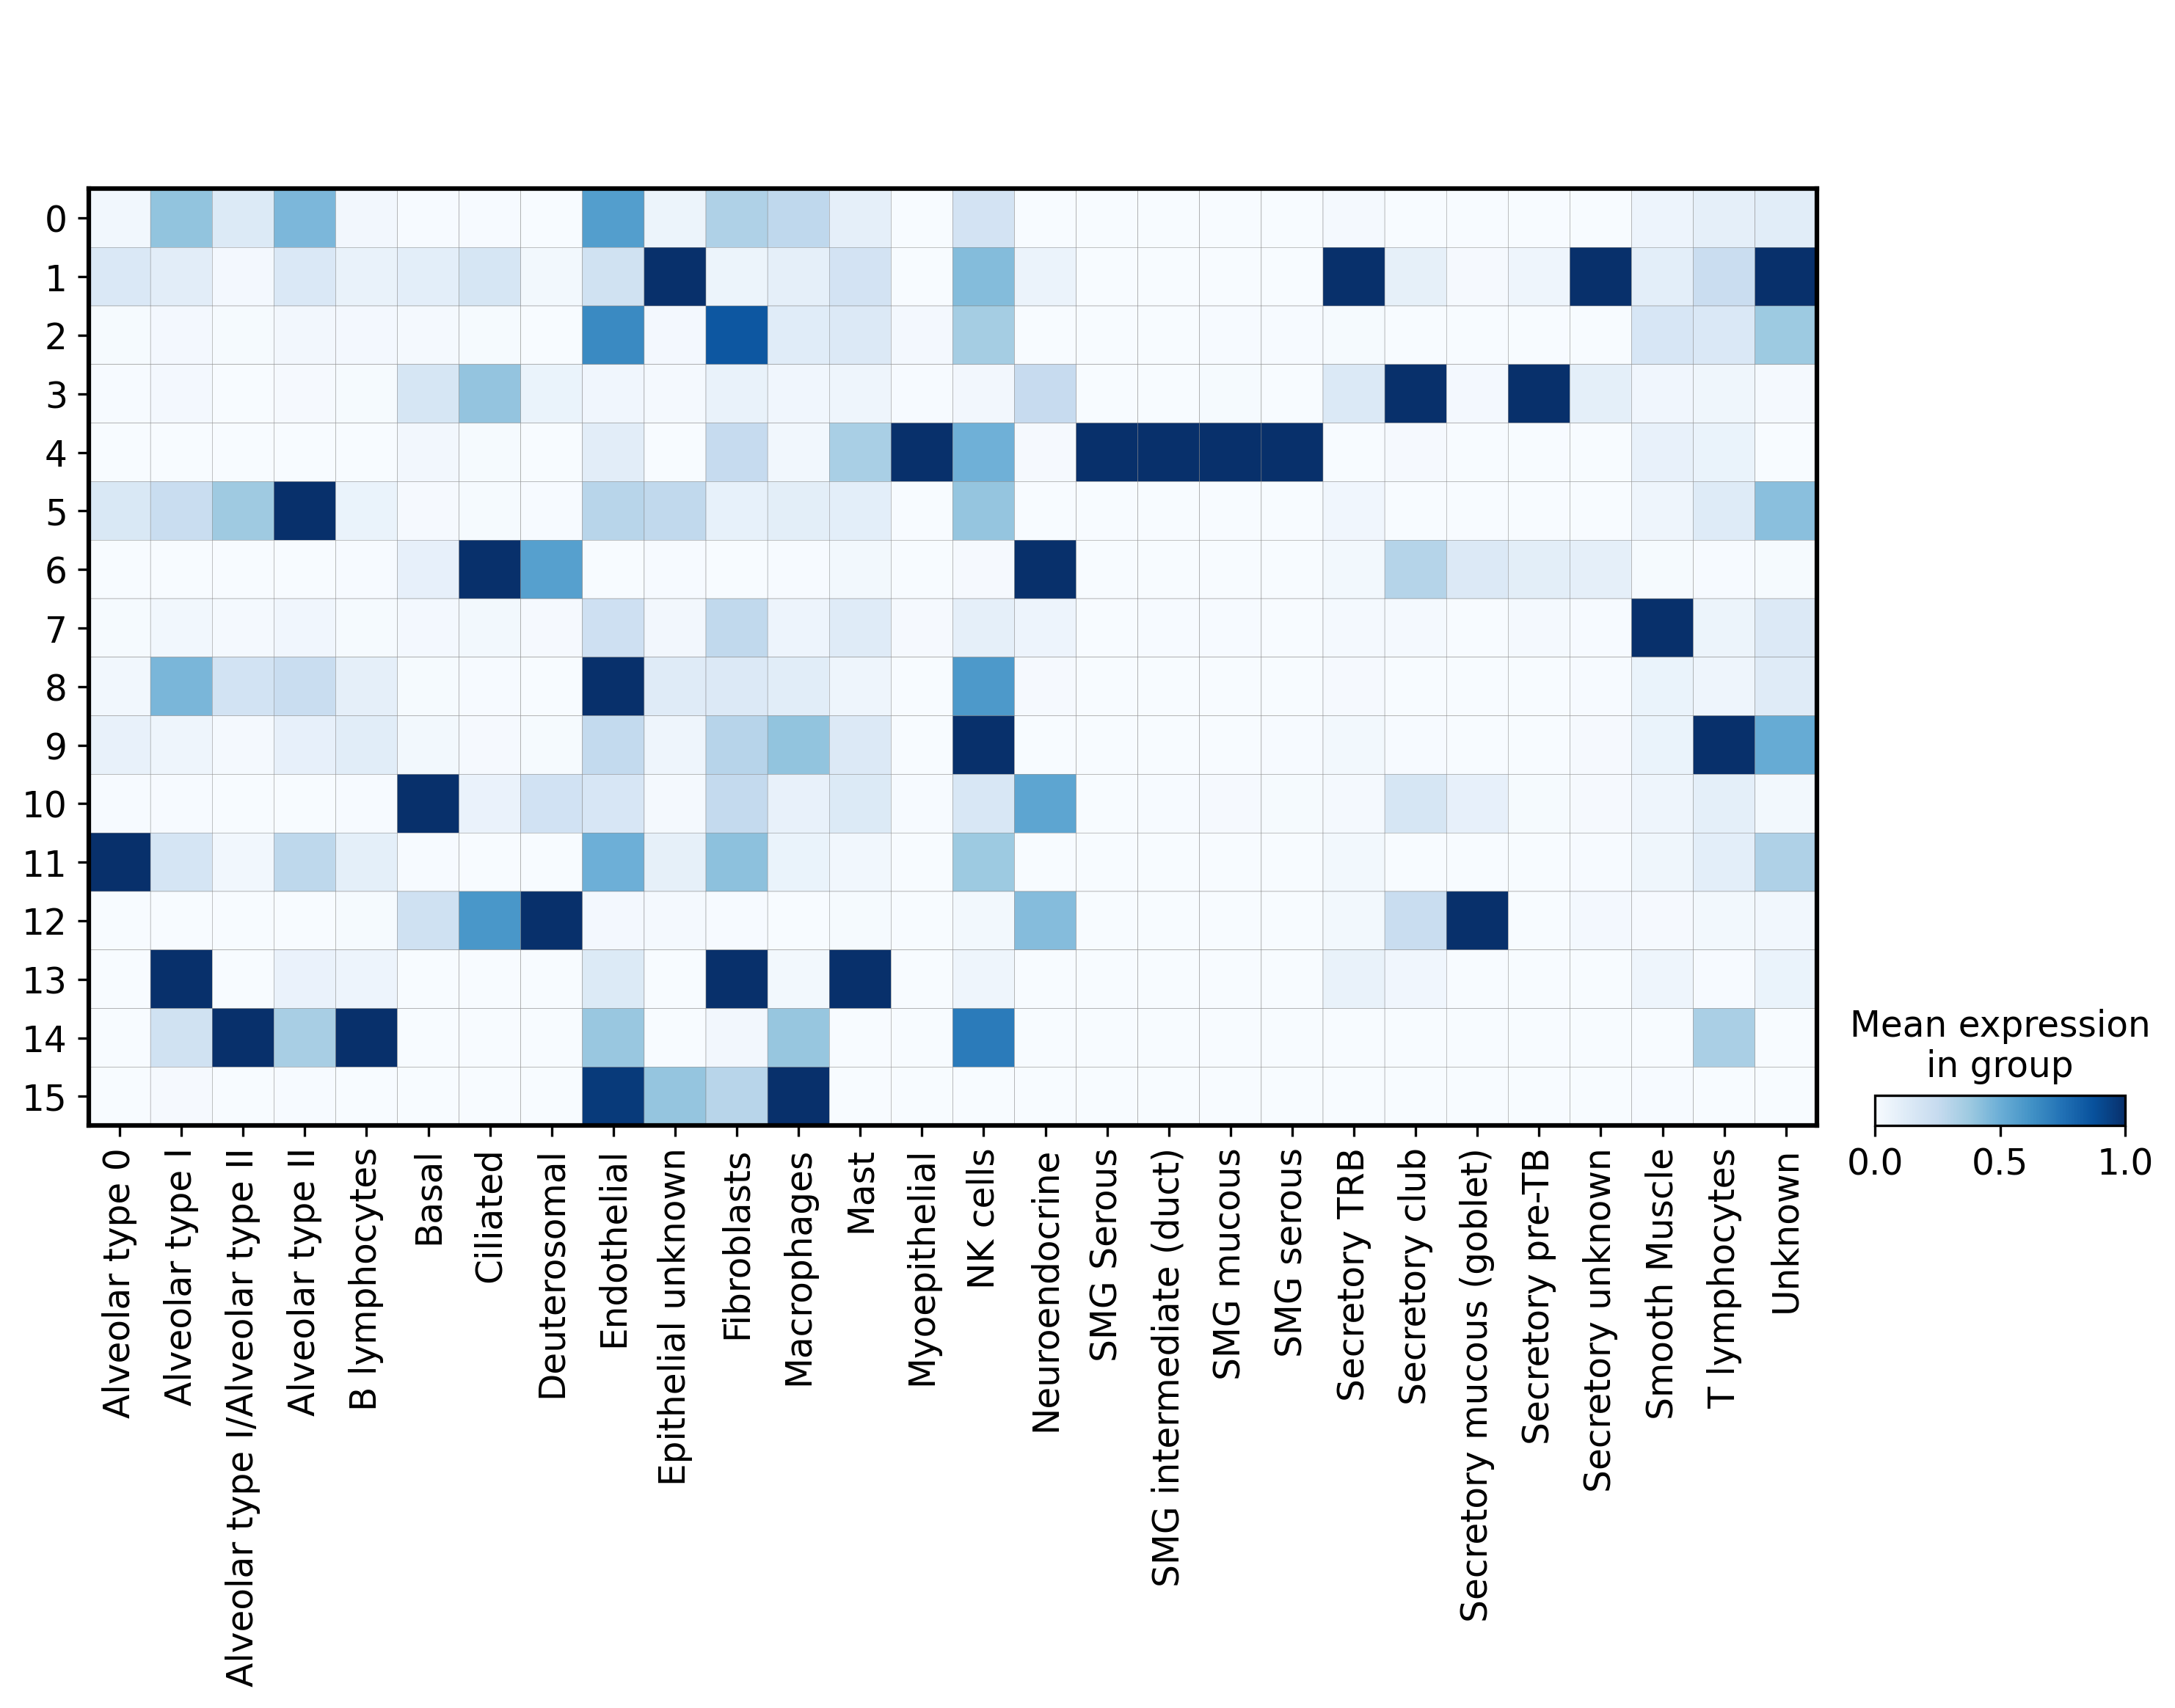

In [5]:
sc.pl.matrixplot(adataneigh,adataneigh.var.index,groupby='domains',standard_scale='var',cmap='Blues')

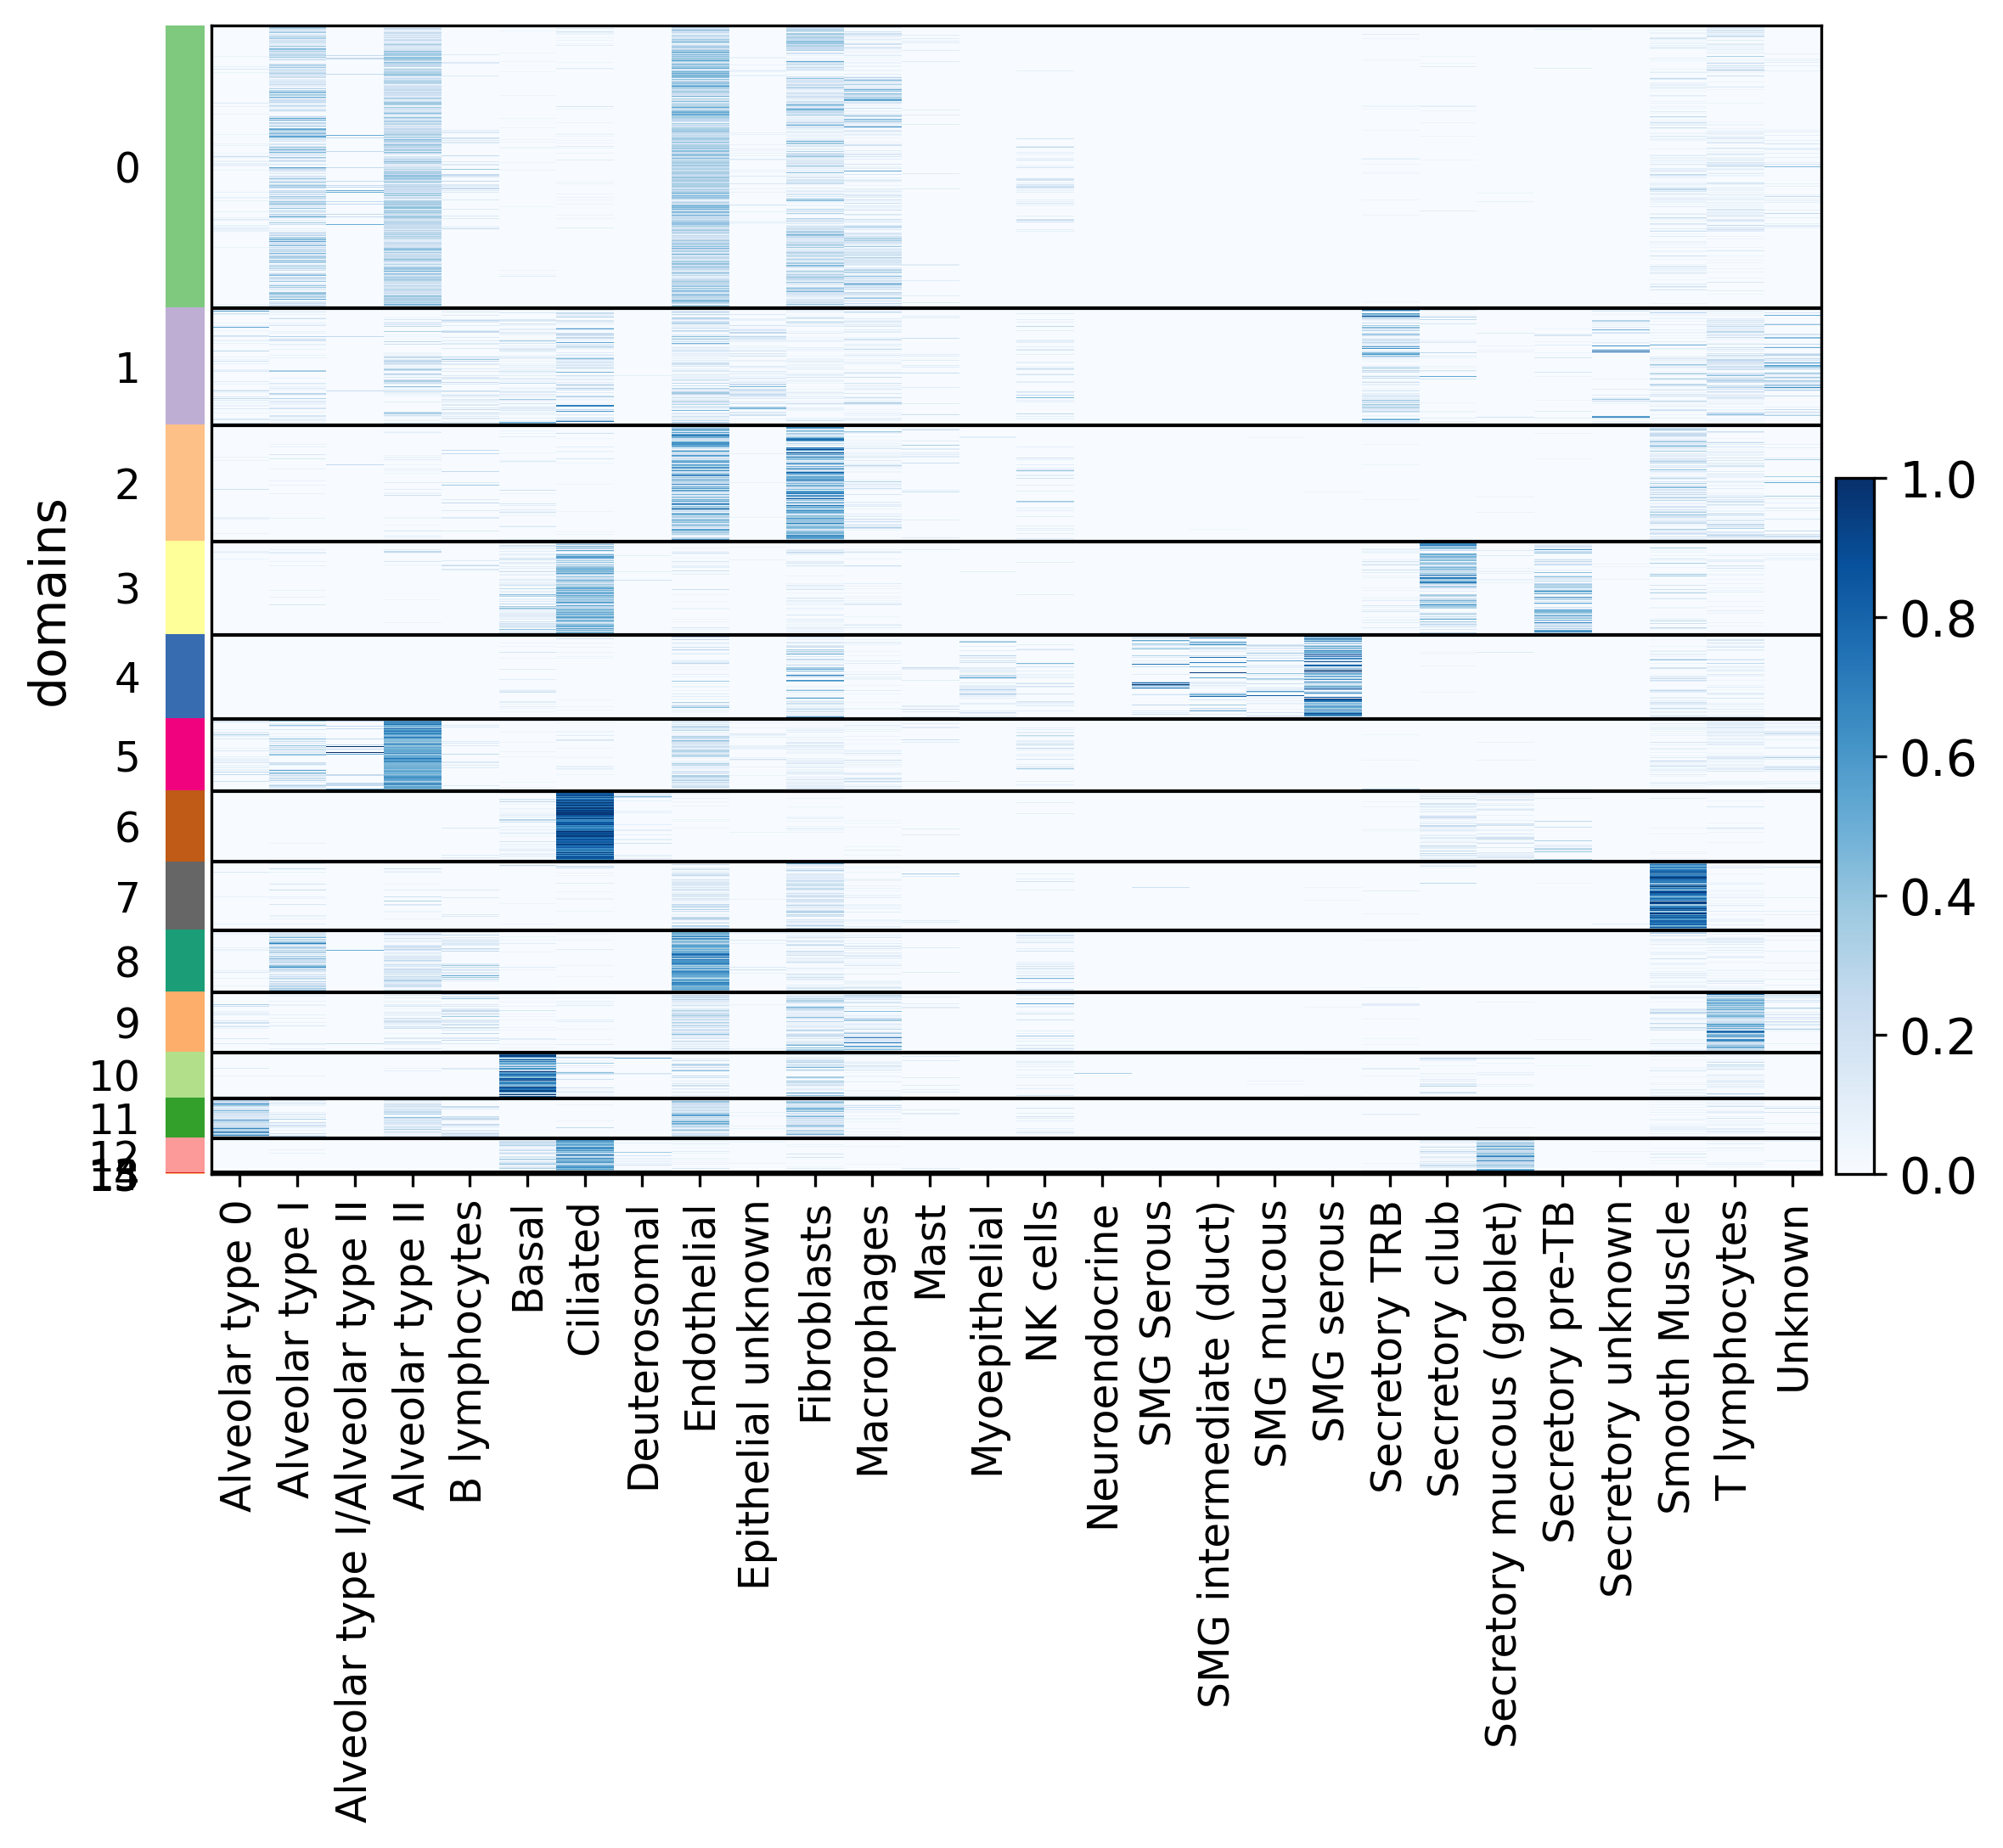

In [11]:
sc.pl.heatmap(adataneigh,adataneigh.var.index,groupby='domains',standard_scale='var',cmap='Blues')

# From here we annotate

In [6]:
annotation={0:'Alveolar',1:'TRB',2:'Parenchyma',3:'Epithelium',4:'SMG',
            5:'Alveolar TII enriched',6:'Epithelium',7:'SMC',8:'Endothelium',9:'Parench. immune',
            10:'Basal',11:'AT0 niche',12:'Epithelium',13:'Alveolar',14:'Immune',15:'Alveolar'}

In [10]:
adataneigh.obs['annotated_domains']=adataneigh.obs['domains'].astype(int).map(annotation)

In [15]:
adataneigh.uns['annotated_domains_colors'] = [
    "#7fc97f",  # Greenish
    "#beaed4",  # Pale Purple
    "#fdc086",  # Light Orange
    "#ffff99",  # Light Yellow
    "#386cb0",  # Dark Blue
    "#f0027f",  # Pinkish
    "#bf5b17",  # Dark Brown
    "#666666",  # Dark Gray
    "#1b9e77",  # Medium Green
    "#fdae6b",  # Light Orange
    "#b2df8a",  # Light Green
    "#33a02c",  # Dark Green
    "#fb9a99",  # Pink
    "#e31a1c",  # Red
    "#fdbf6f",  # Medium Orange
    "#ff7f00",  # Dark Orange
    "#cab2d6",  # Light Purple
    "#6a3d9a",  # Dark Purple
    "#b15928",  # Dark Orange
    "#e7298a",  # Magenta
    "#66a61e",  # Olive Green
    "#d95f02",  # Dark Orange
    "#7570b3",  # Purple
    "#e6ab02",  # Yellow Orange
    "#a6761d"   # Dark Yellow
]


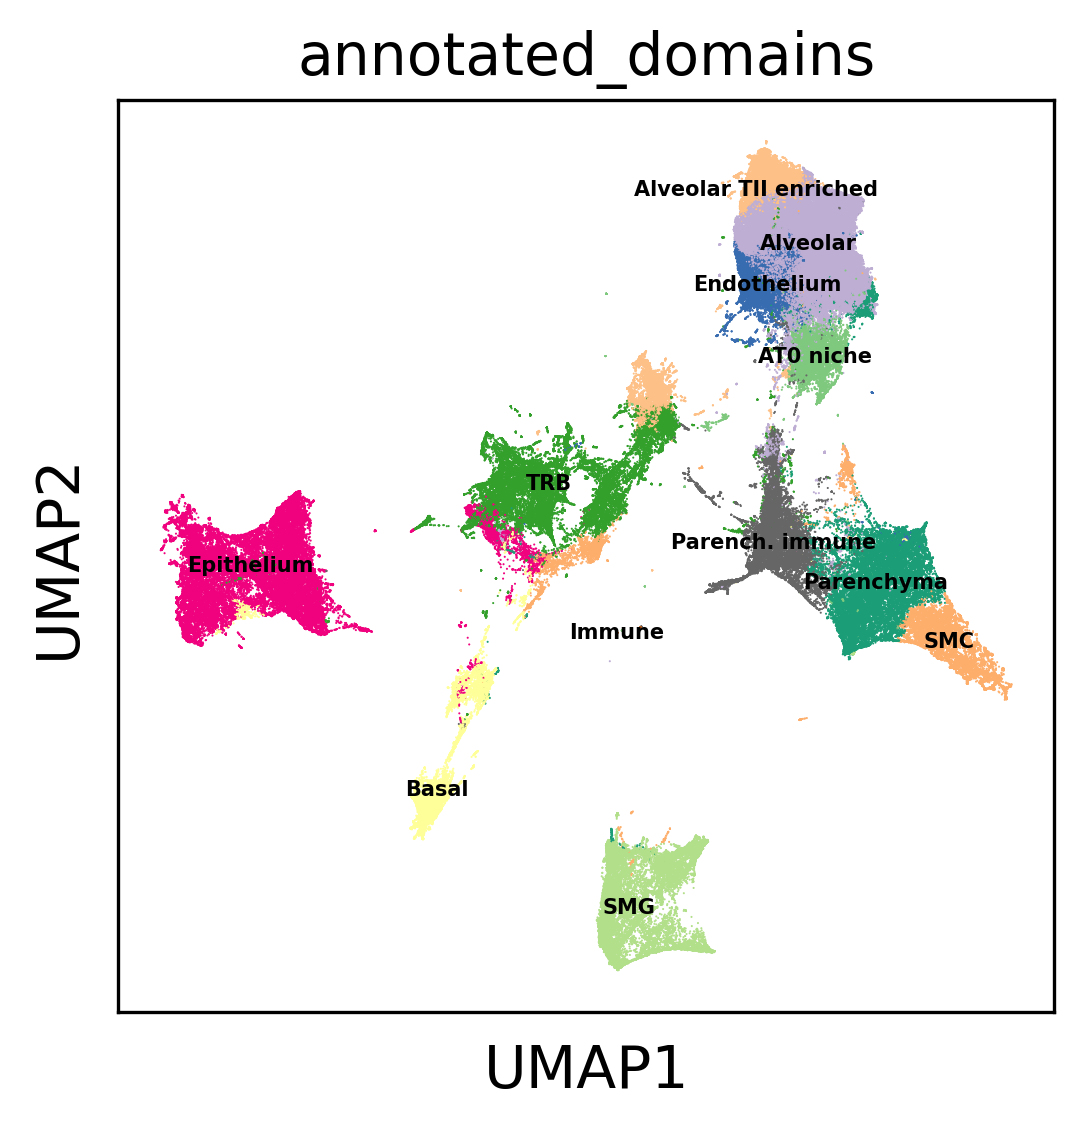

In [16]:
sc.set_figure_params(scanpy=True, dpi=150, dpi_save=150, frameon=True, vector_friendly=True, fontsize=14, figsize=None, color_map=None, format='pdf', facecolor='white', transparent=False, ipython_format='png2x')
sc.pl.umap(adataneigh,color=['annotated_domains'],s=1,ncols=1,legend_loc='on data',legend_fontsize=5)#,save='UMAP_10X_colors.svg')

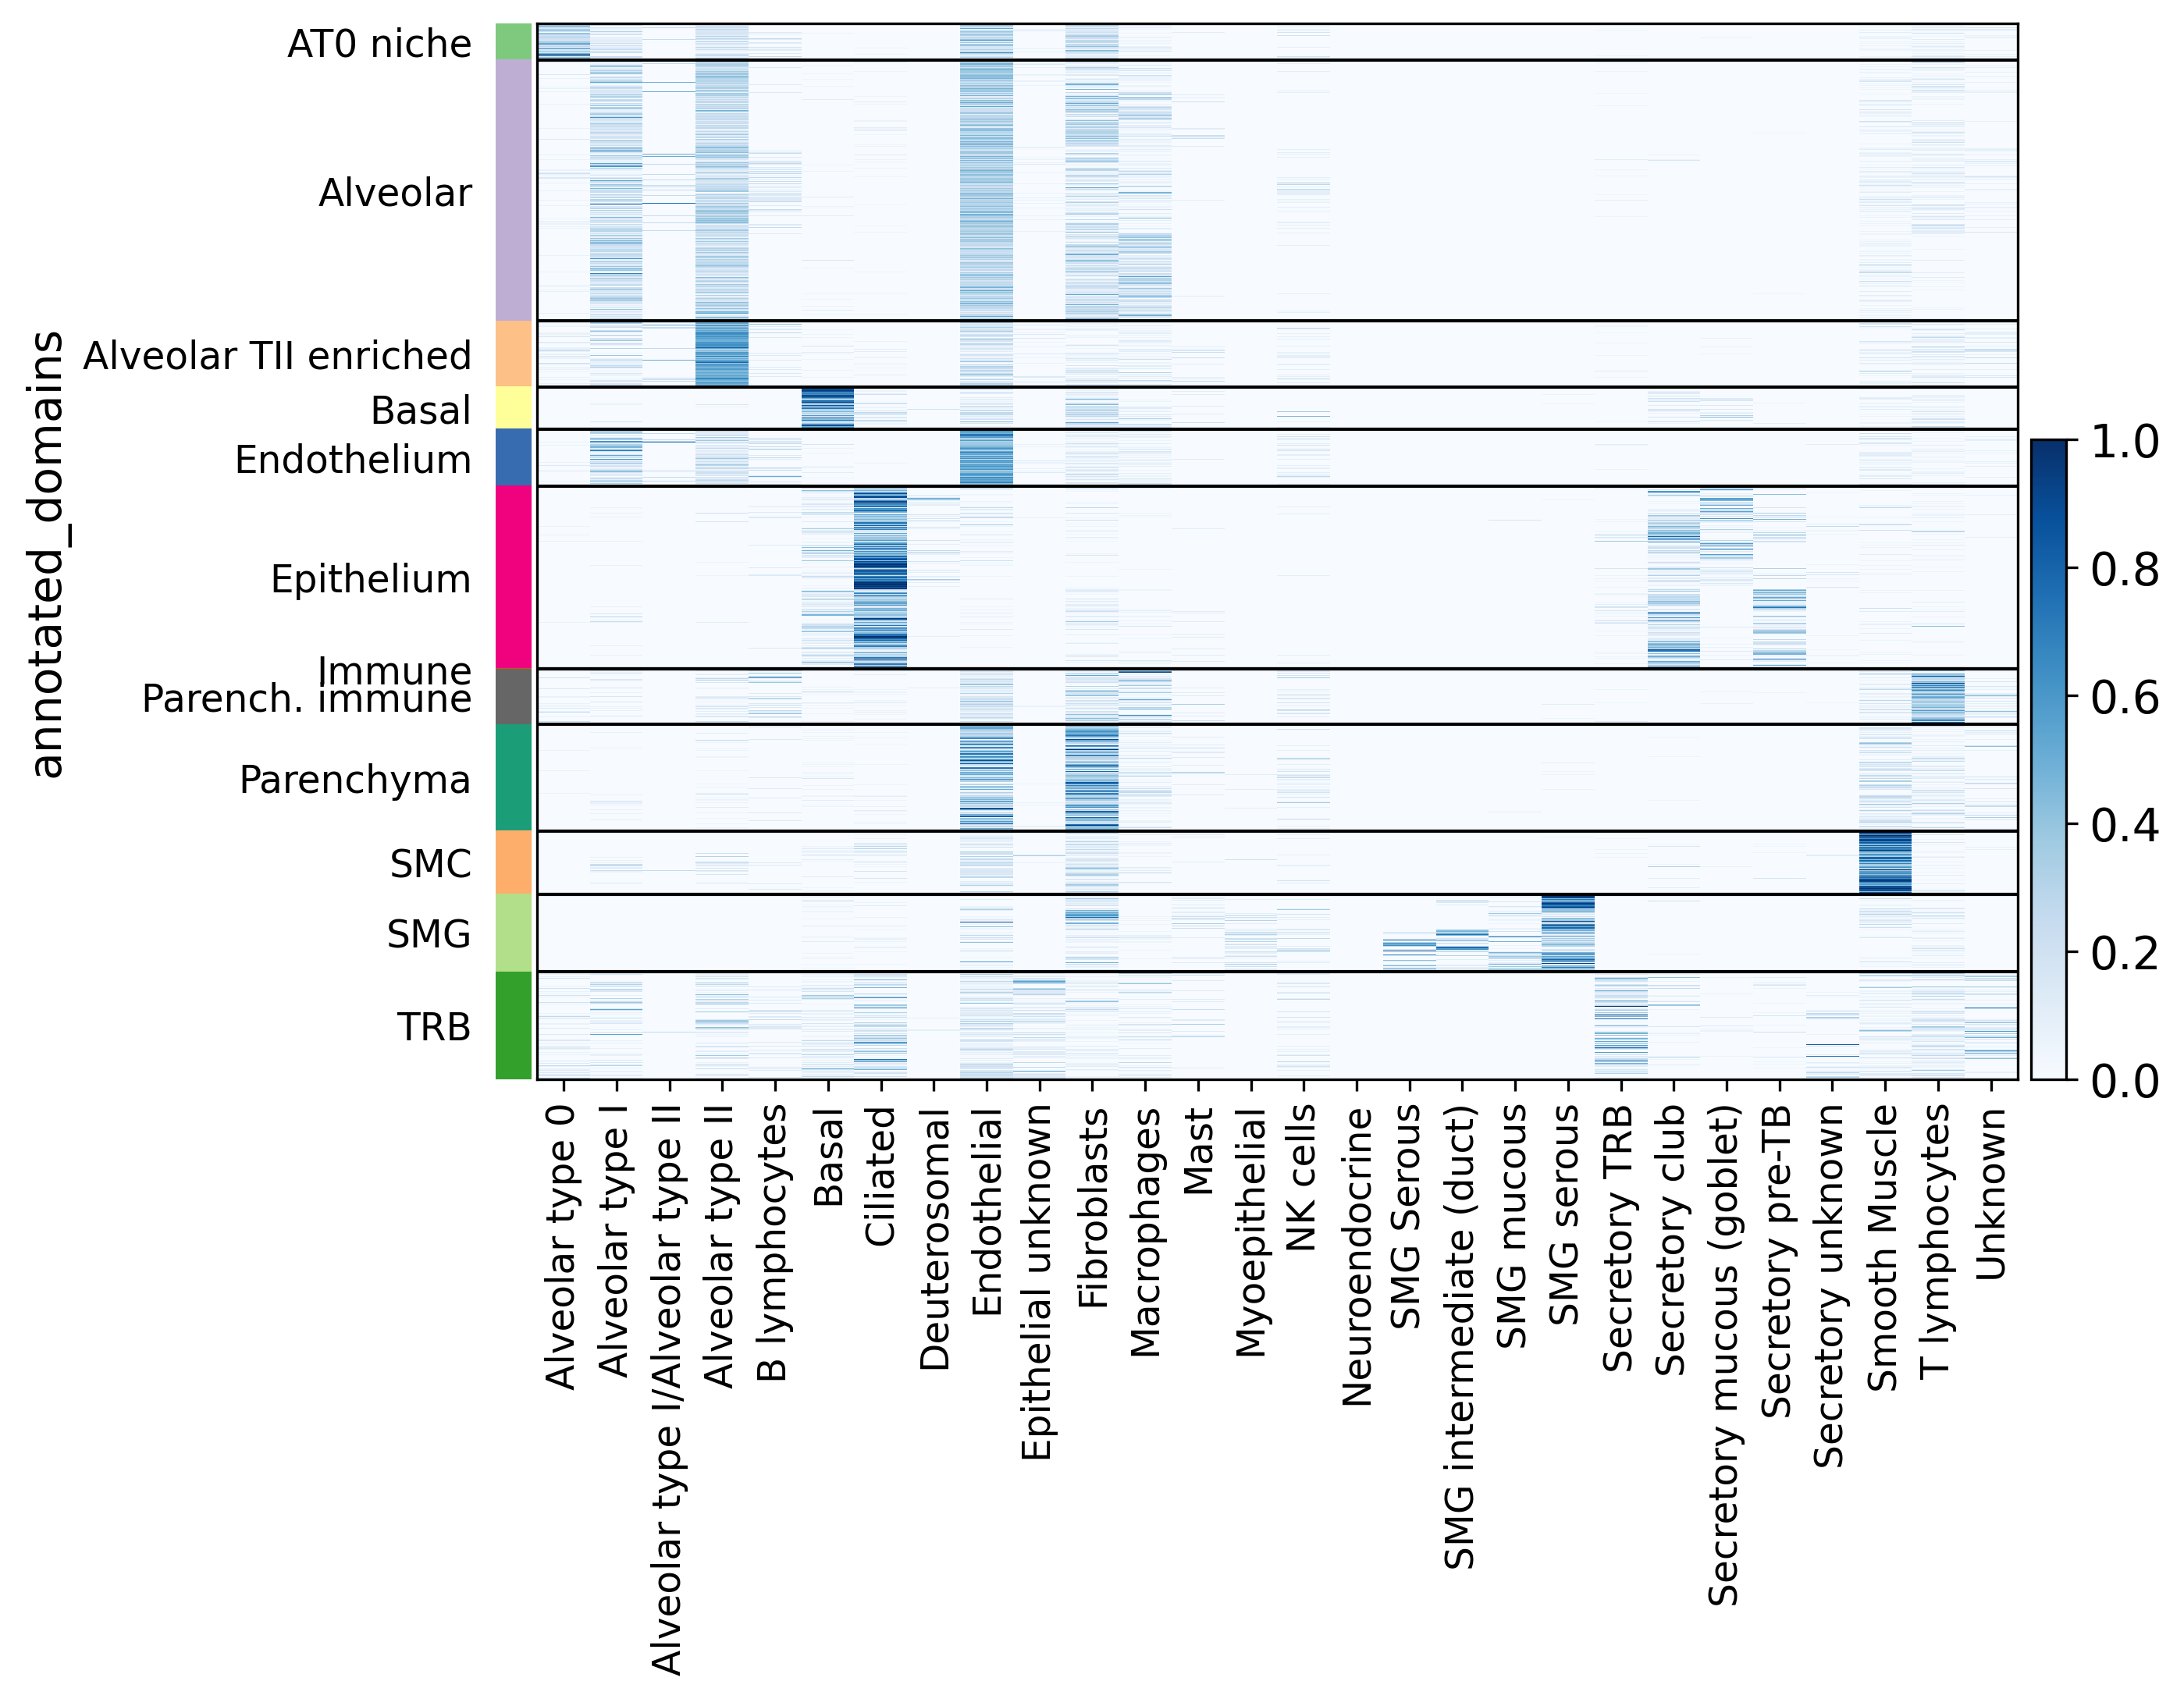

In [18]:
sc.pl.heatmap(adataneigh,adataneigh.var.index,groupby='annotated_domains',standard_scale='var',cmap='Blues')

In [32]:
adataneigh2

AnnData object with n_obs × n_vars = 13347 × 28
    obs: 'index', 'region', 'sample', 'donor', 'condition', 'smoking', 'gender', 'cell', 'roi', 'x', 'y', 'area', 'clusters-pc7', 'cellclass', 'celltype', 'cellsubtype', 'donor_name', 'reg', 'sample_name', 'image', 'name', 'total_counts', 'n_genes', 'n_counts', 'domains', 'X', 'Y', 'annotated_domains'
    uns: 'condition_colors', 'donor_colors', 'leiden', 'neighbors', 'reg_colors', 'sample_colors', 'umap', 'domains_annoated_colors', 'annotated_domains_colors', 'spatial_neighbors'
    obsm: 'X_umap', 'spatial'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'

In [58]:
diccol=dict(zip(np.unique(adataneigh.obs['annotated_domains']),adataneigh.uns['annotated_domains_colors']))

In [ ]:
sc.set_figure_params(scanpy=True, dpi=250, dpi_save=250, frameon=True, vector_friendly=True, fontsize=14, figsize=None, color_map=None, format='pdf', facecolor='white', transparent=False, ipython_format='png2x')
adataneigh.obs['X']=adataneigh.obs['x']
adataneigh.obs['Y']=adataneigh.obs['y']
key='annotated_domains'
for sam in adataneigh.obs['sample'].unique():
    print(sam)
    
    adataneigh2=adataneigh[adataneigh.obs['sample']==sam]
    adataneigh2.uns['annotated_domains_colors']=[diccol[e] for e in np.unique(adataneigh2.obs['annotated_domains'])]
    print(adataneigh2.obs['donor'][0]+'_'+str(adataneigh2.obs['condition'][0]))
    sc.pl.umap(adataneigh2,color=[key])#,save='UMAP_10X_colors.svg')
    sq.gr.spatial_neighbors(adataneigh2,spatial_key='spatial', radius=100,coord_type="generic")
#    sq.pl.spatial_scatter(adataneigh2,color=key,spot_size=30,edges=True,connectivity_key='spatial_connectivities',img=False,
#                         library_id=None)
    sc.pl.spatial(adataneigh2,color=key,neighbors_key='spatial_neighbors',spot_size=40,edges=True,edges_width=0.1,
                 edges_color='#bcbcbc')
    #map_of_clusters(adataneigh2,key=key,size=6,background='white',figuresize=(7,7))

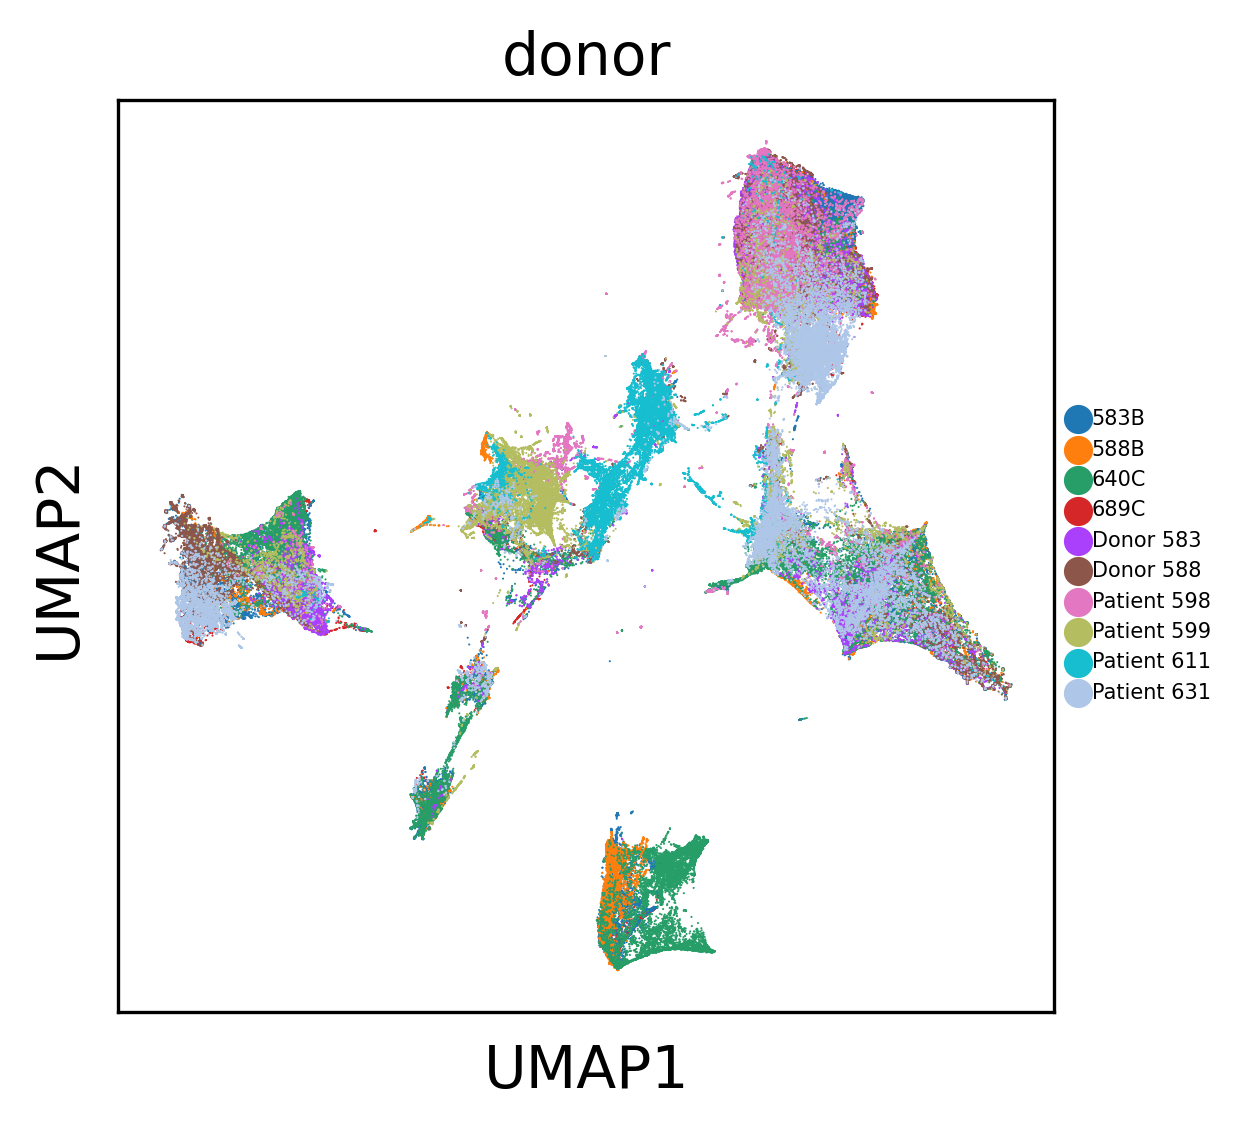

In [19]:
sc.set_figure_params(scanpy=True, dpi=150, dpi_save=150, frameon=True, vector_friendly=True, fontsize=14, figsize=None, color_map=None, format='pdf', facecolor='white', transparent=False, ipython_format='png2x')
sc.pl.umap(adataneigh,color=['donor'],s=1,ncols=1,legend_fontsize=5)#,save='UMAP_10X_colors.svg')

In [ ]:
sc.set_figure_params(scanpy=True, dpi=150, dpi_save=150, frameon=True, vector_friendly=True, fontsize=14, figsize=None, color_map=None, format='pdf', facecolor='white', transparent=False, ipython_format='png2x')
sc.pl.umap(adataneigh,color=['sample','reg','condition'],s=1,ncols=1,legend_fontsize=5)#,save='UMAP_10X_colors.svg')

Text(0, 0.5, 'relative abundance across groups')

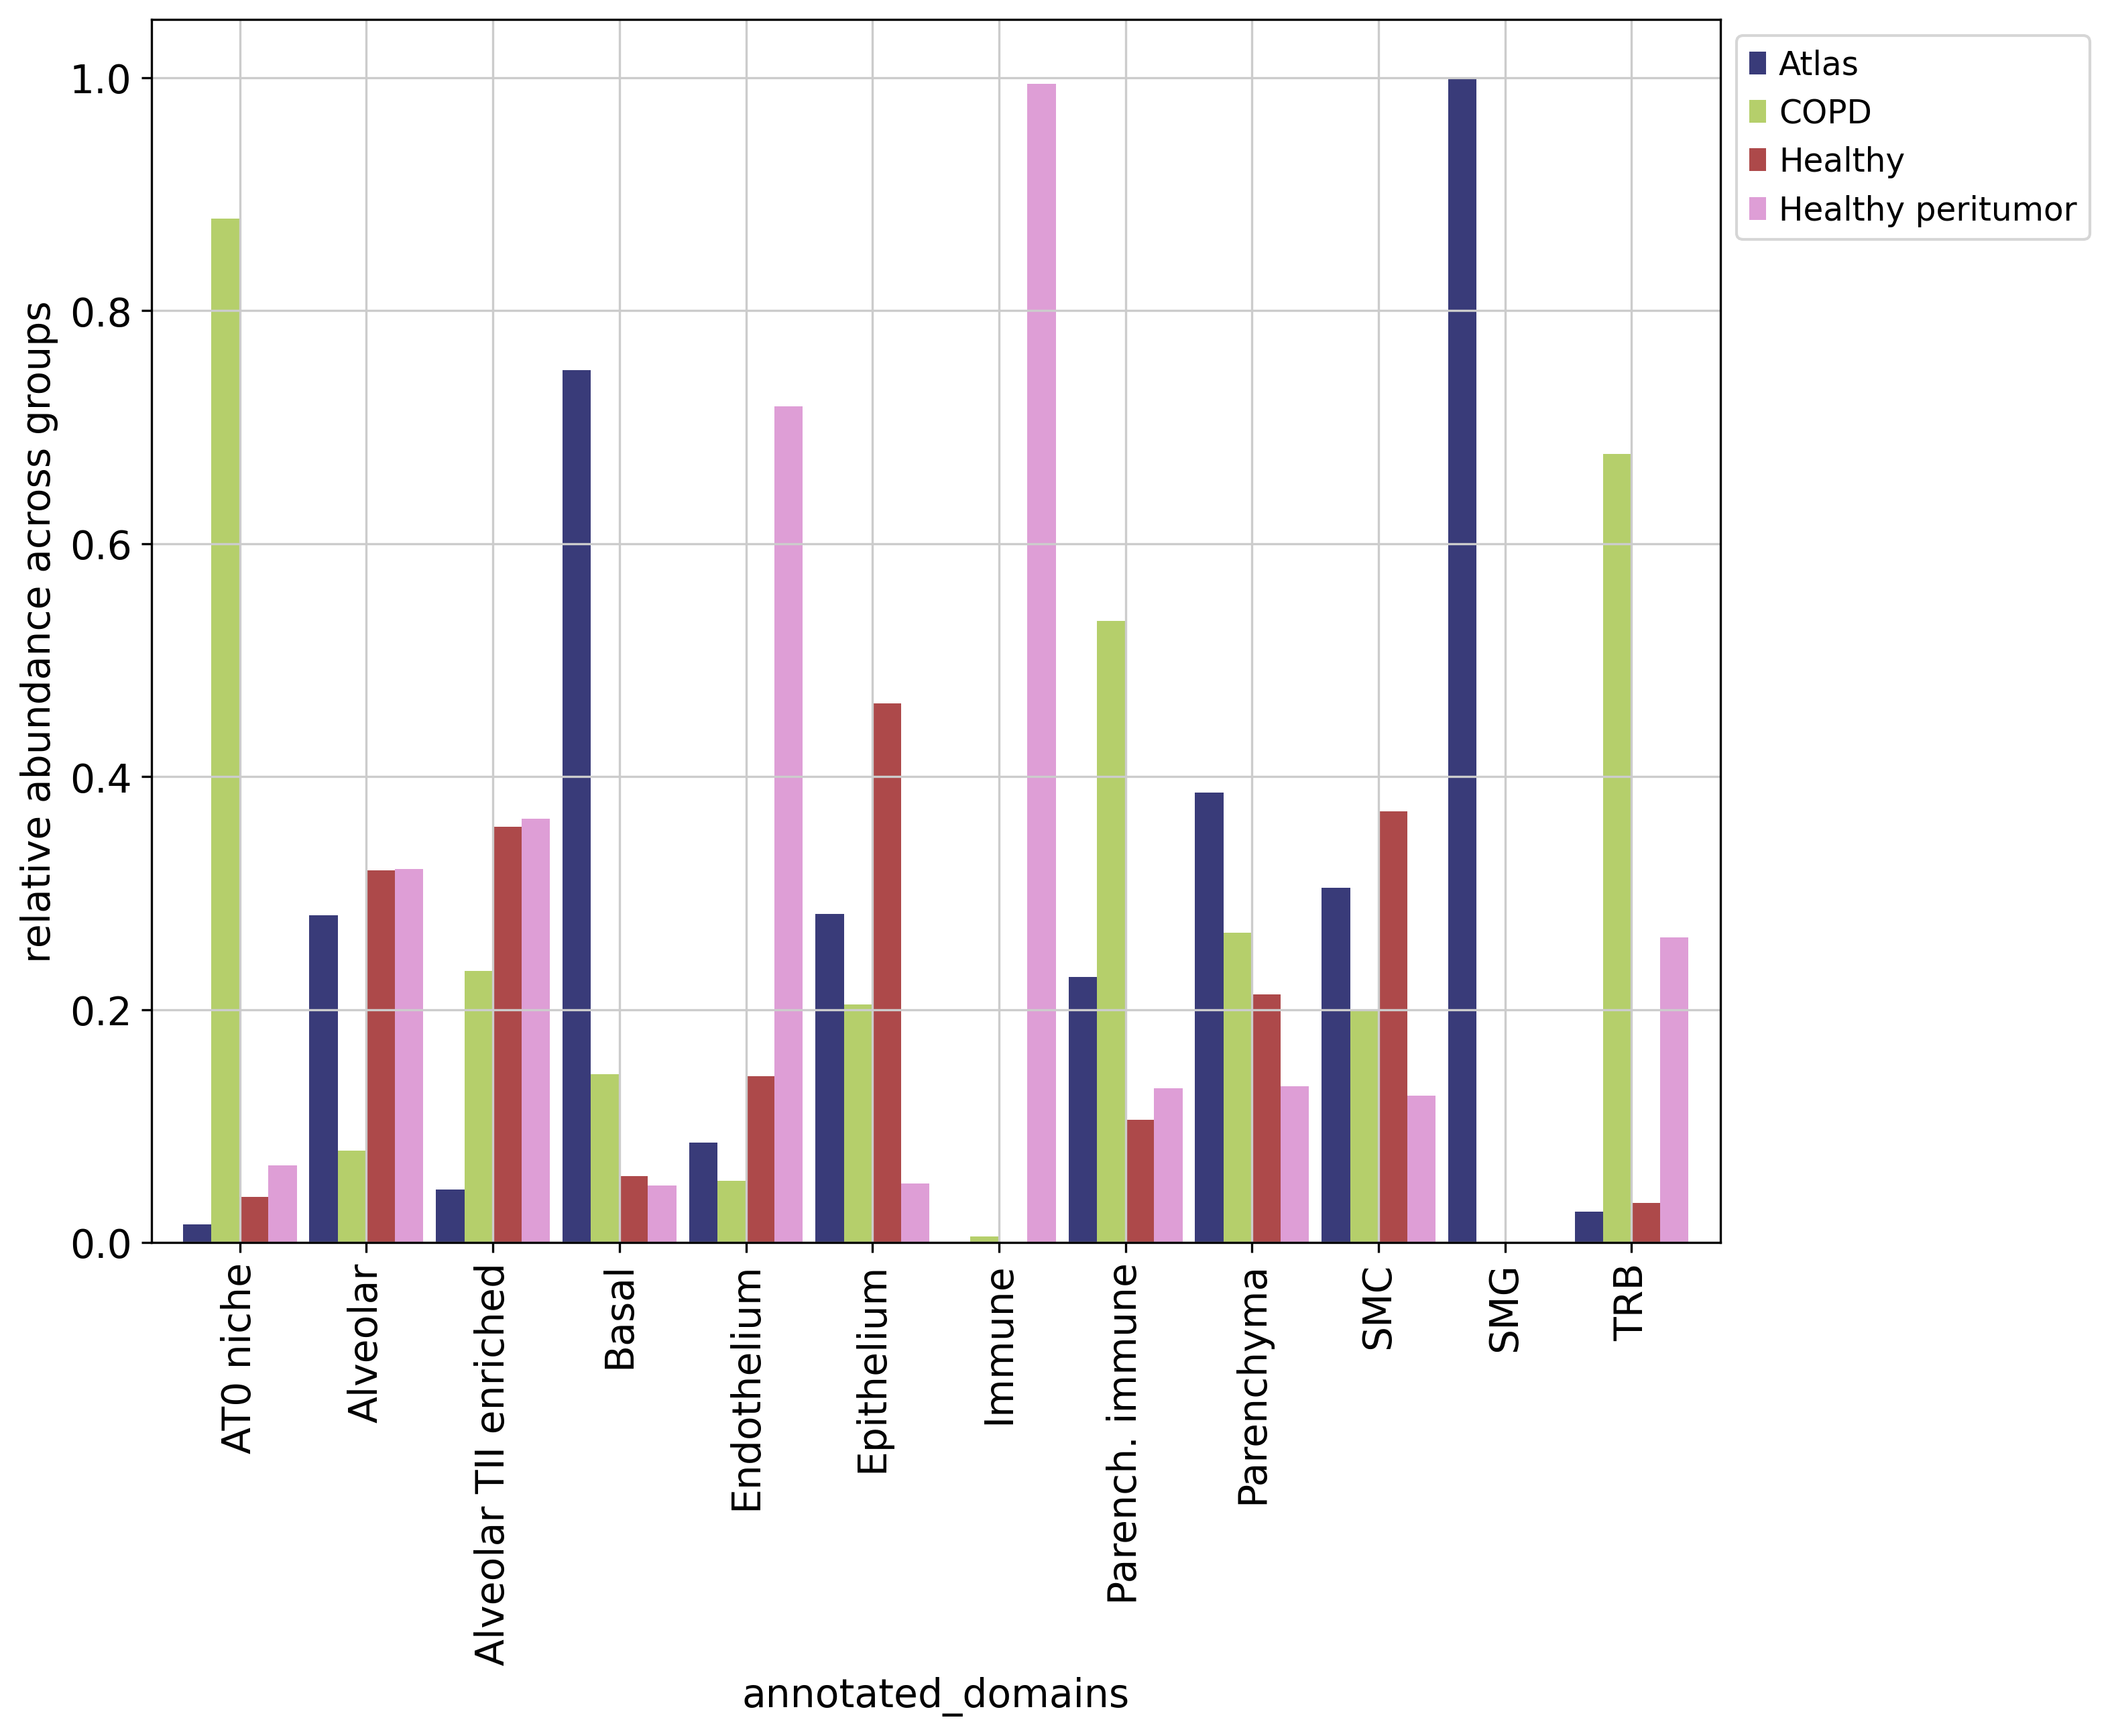

In [26]:
ctb=pd.crosstab(adataneigh.obs['annotated_domains'],adataneigh.obs['condition'])
ctb_sub=ctb.div(ctb.sum(axis=0),axis=1)
ctb_sub=ctb_sub.div(ctb_sub.sum(axis=1),axis=0)
ctb_sub.plot(kind='bar',width=0.9,figsize=(10,8),cmap='tab20b').legend(
    bbox_to_anchor=(1.0, 1.0),
    fontsize='small',
)
plt.ylabel('relative abundance across groups')

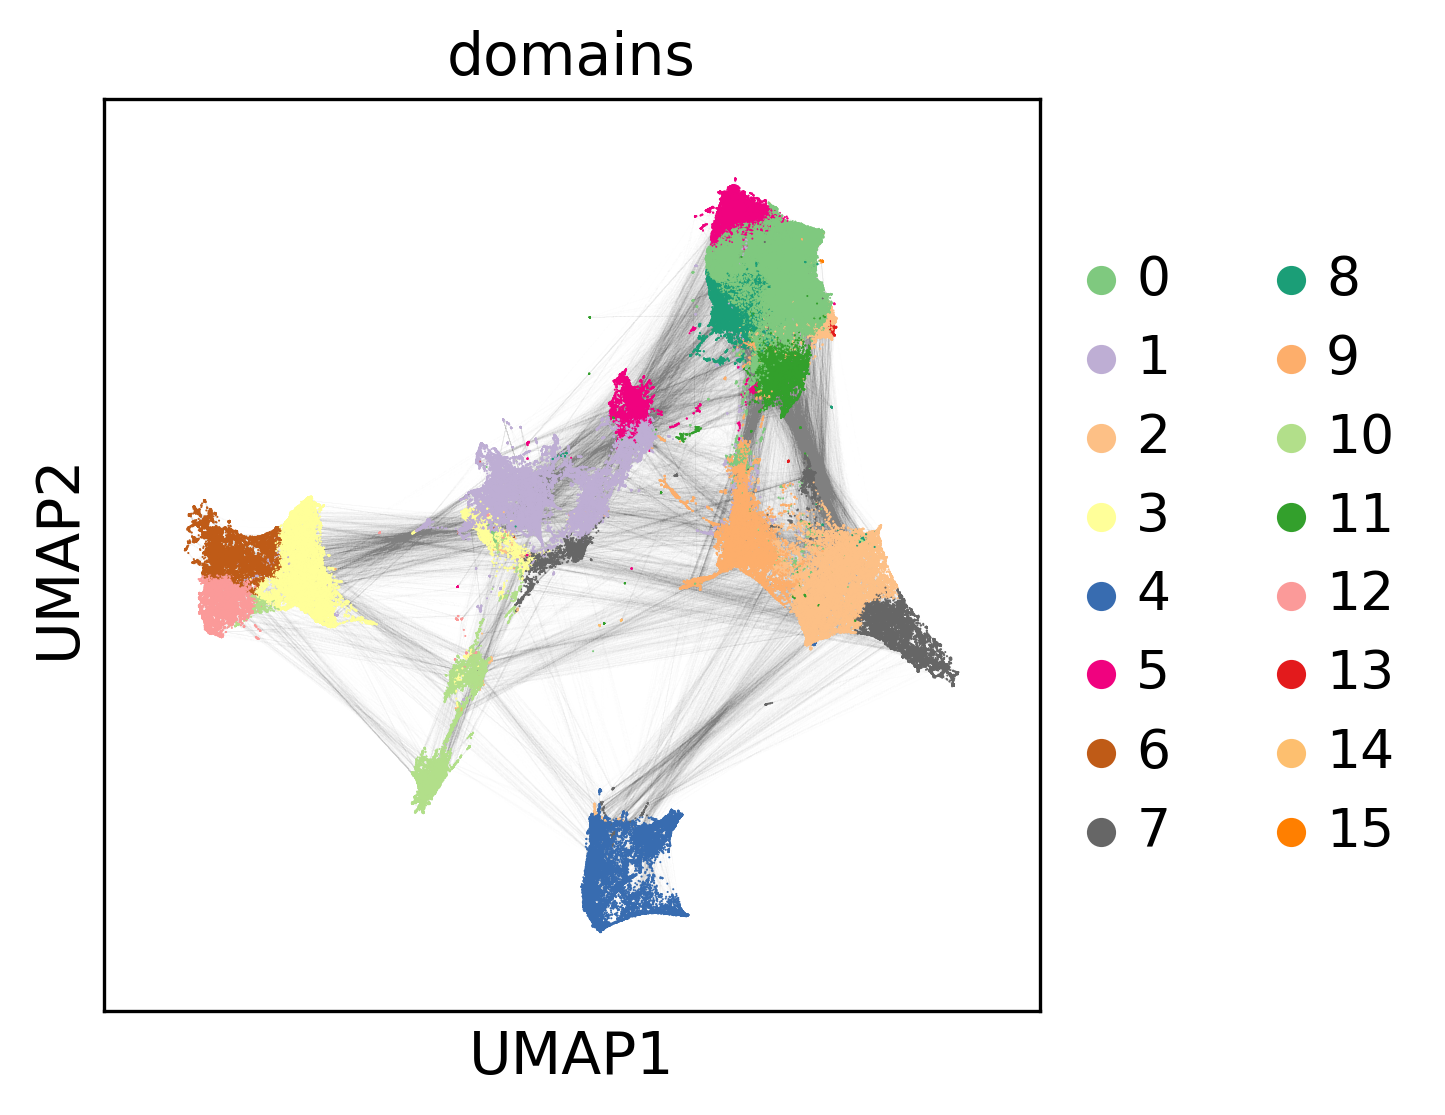

In [52]:
sc.set_figure_params(scanpy=True, dpi=150, dpi_save=150, frameon=True, vector_friendly=True, fontsize=14, figsize=None, color_map=None, format='pdf', facecolor='white', transparent=False, ipython_format='png2x')
sc.pl.umap(adataneigh,color=['domains'],s=1,ncols=1,edges=True,edges_width=0.0001)#,save='UMAP_10X_colors.svg')

In [ ]:
sc.set_figure_params(scanpy=True, dpi=80, dpi_save=150, frameon=True, vector_friendly=True, fontsize=14, figsize=None, color_map=None, format='pdf', facecolor='white', transparent=False, ipython_format='png2x')
sc.pl.umap(adataneigh,color=['sample','reg','domains','condition'],s=1,ncols=1)#,save='UMAP_10X_colors.svg')

In [ ]:
sc.pl.matrixplot(adataneigh,adataneigh.var.index,groupby='domains')

In [ ]:
for c in adataneigh.to_df().columns:
    sc.pl.umap(adataneigh,color=c)

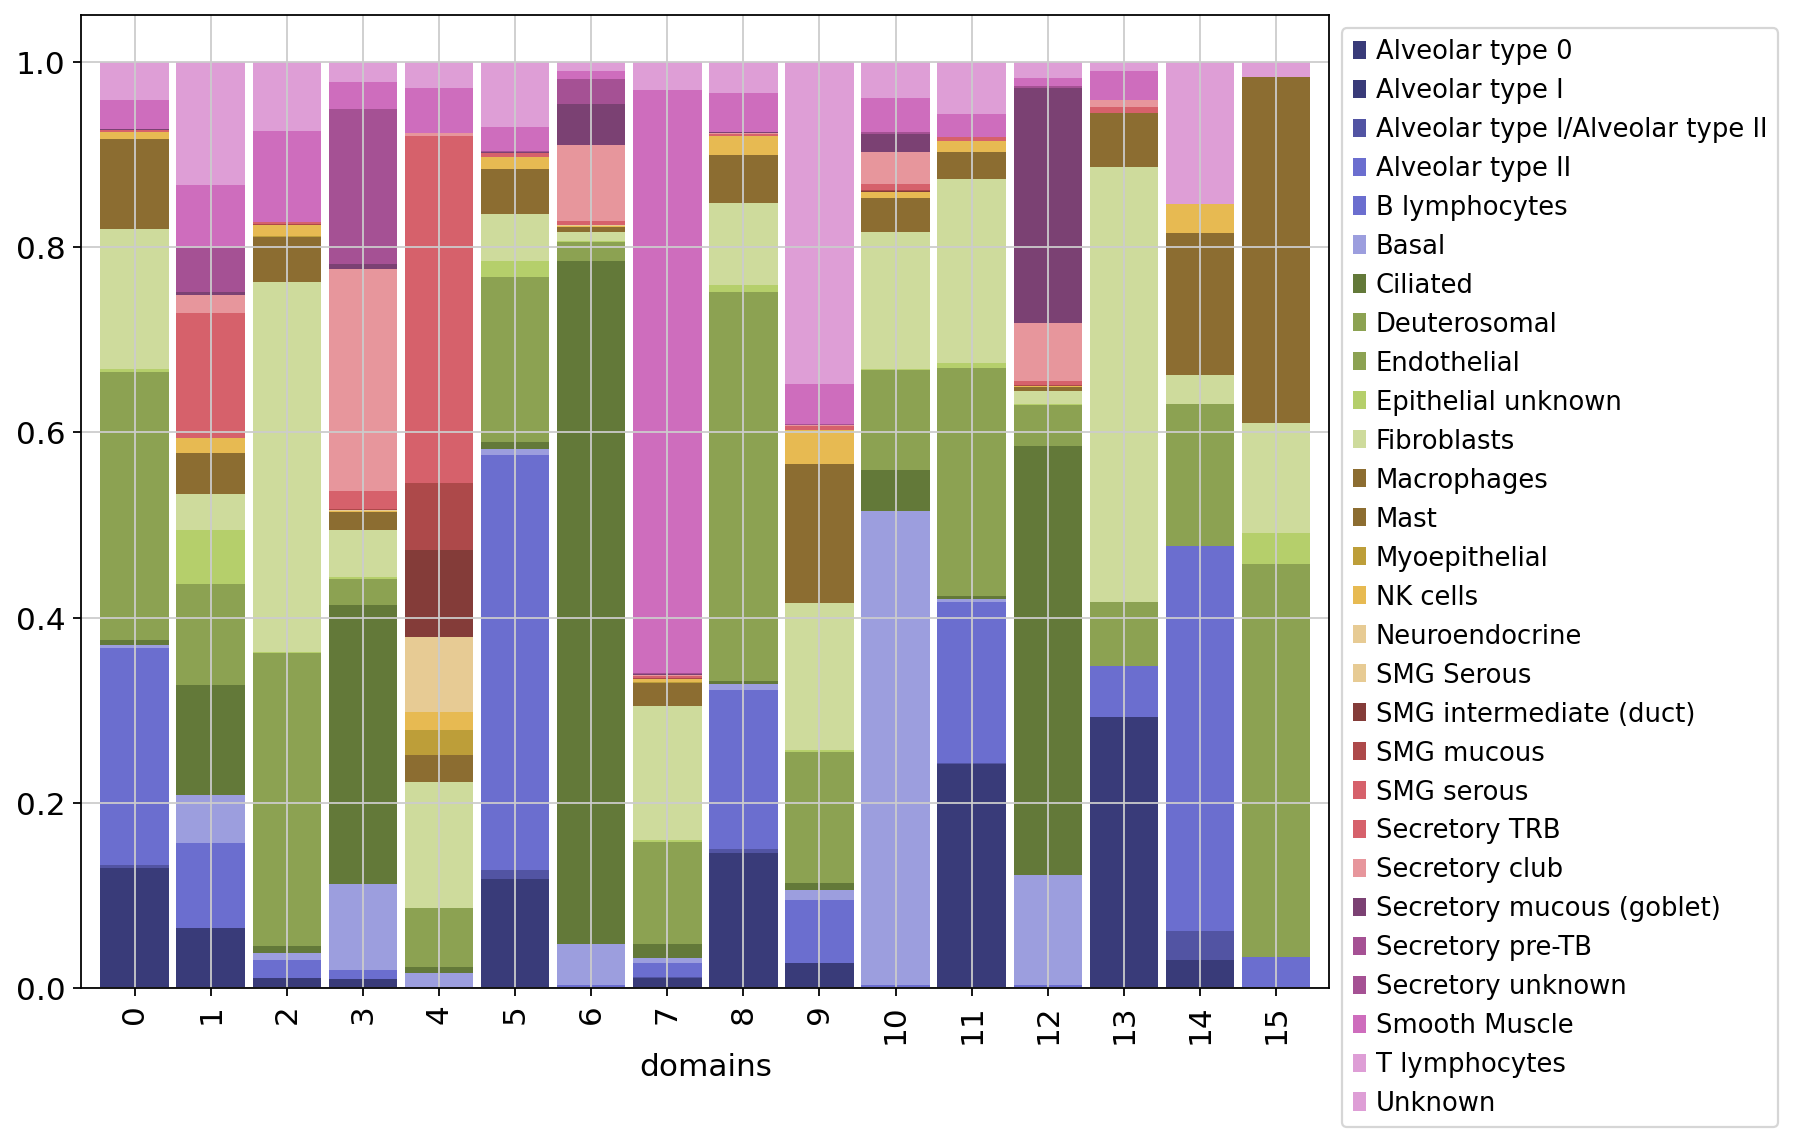

In [57]:
ctb=pd.crosstab(adataneigh.obs['domains'],adataneigh.obs['celltype'])
ctb_sub=ctb.div(ctb.sum(axis=1),axis=0)
ctb_sub.plot(kind='bar',stacked=True,width=0.9,figsize=(10,8),cmap='tab20b').legend(
    bbox_to_anchor=(1.0, 1.0),
    fontsize='small',
)

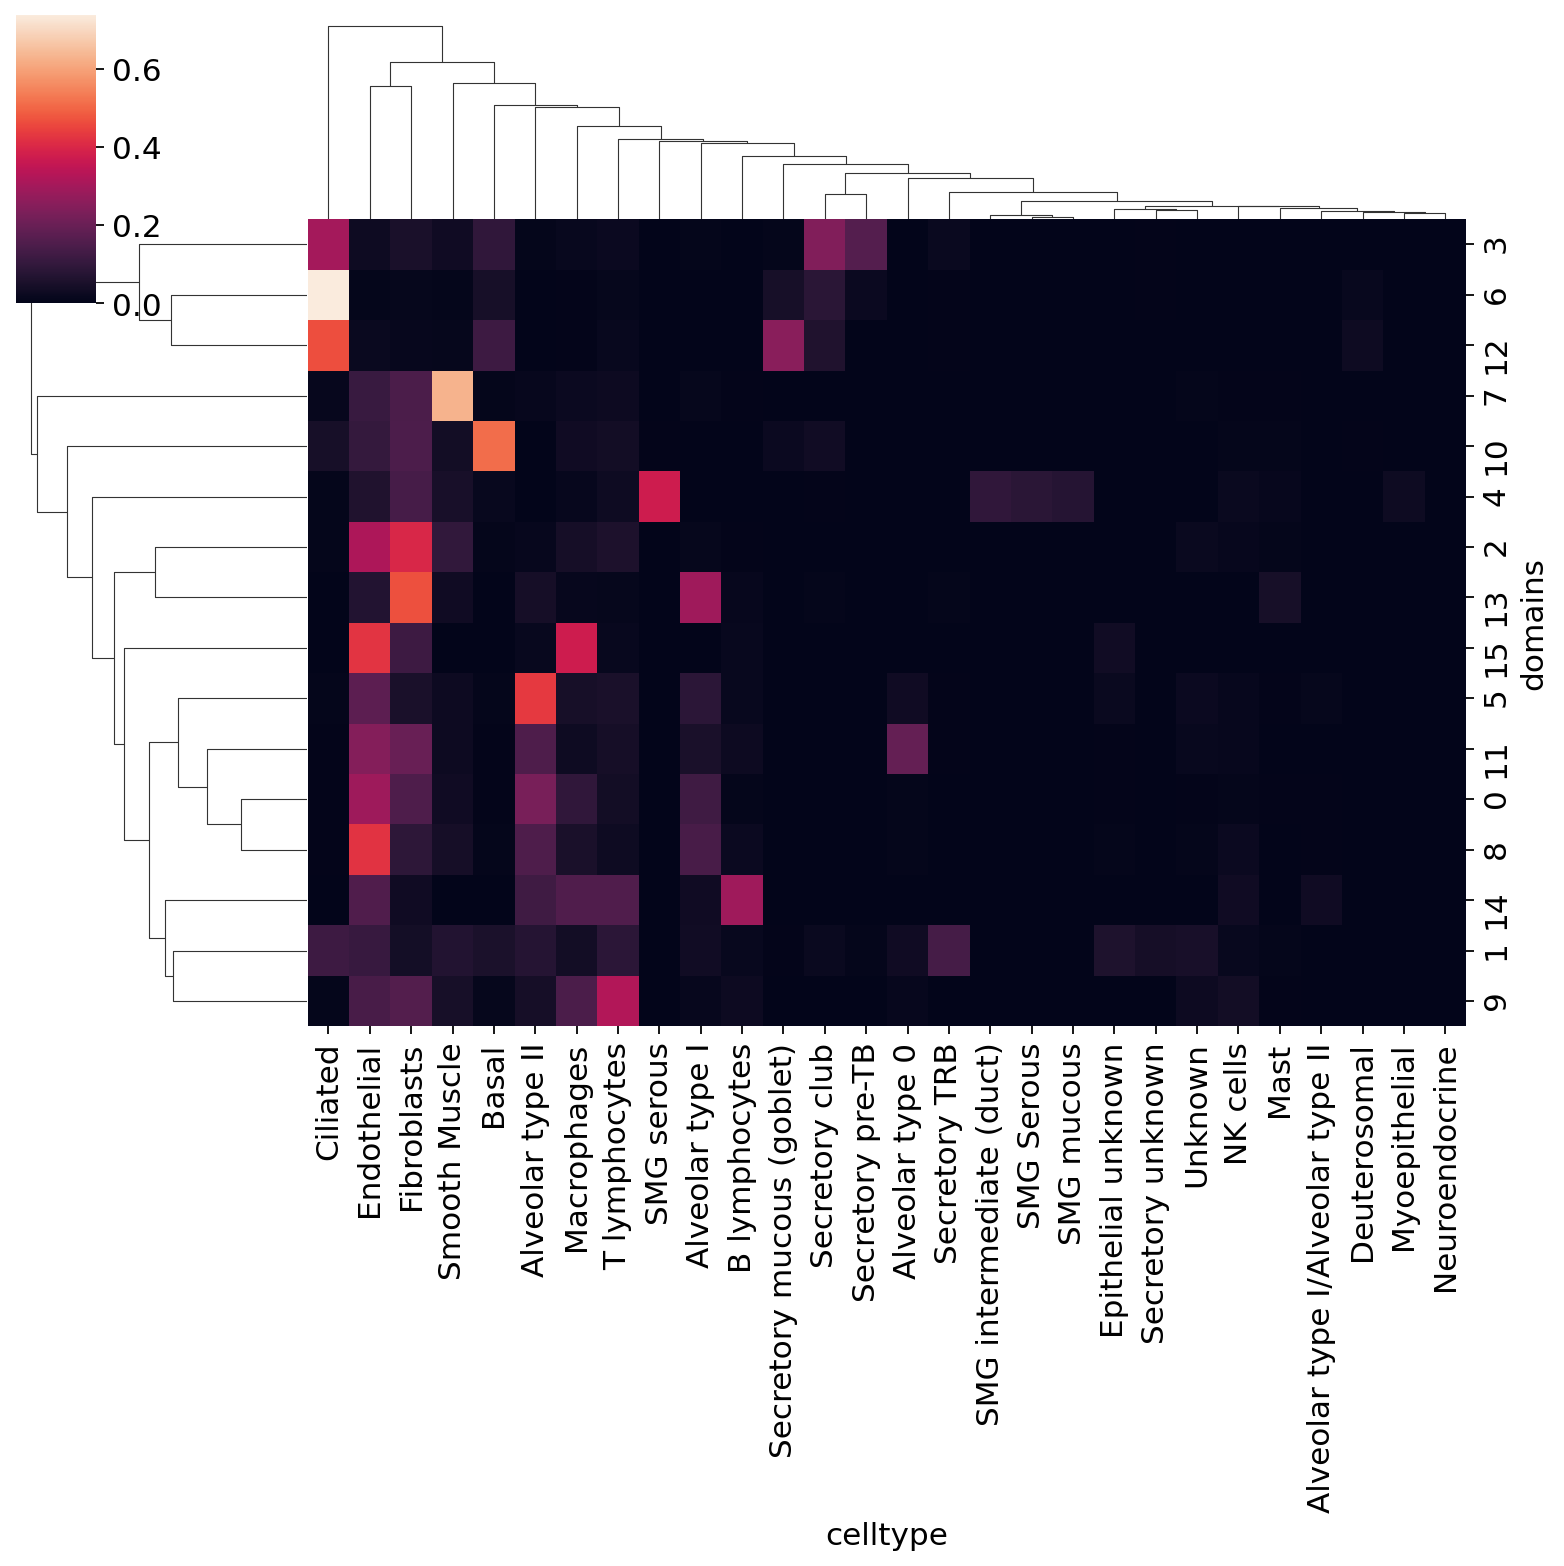

In [58]:
import seaborn as sns
sns.clustermap(ctb_sub,figsize=(10,10))

In [59]:
d2cond=dict(zip(adataneigh.obs['donor'],adataneigh.obs['condition']))

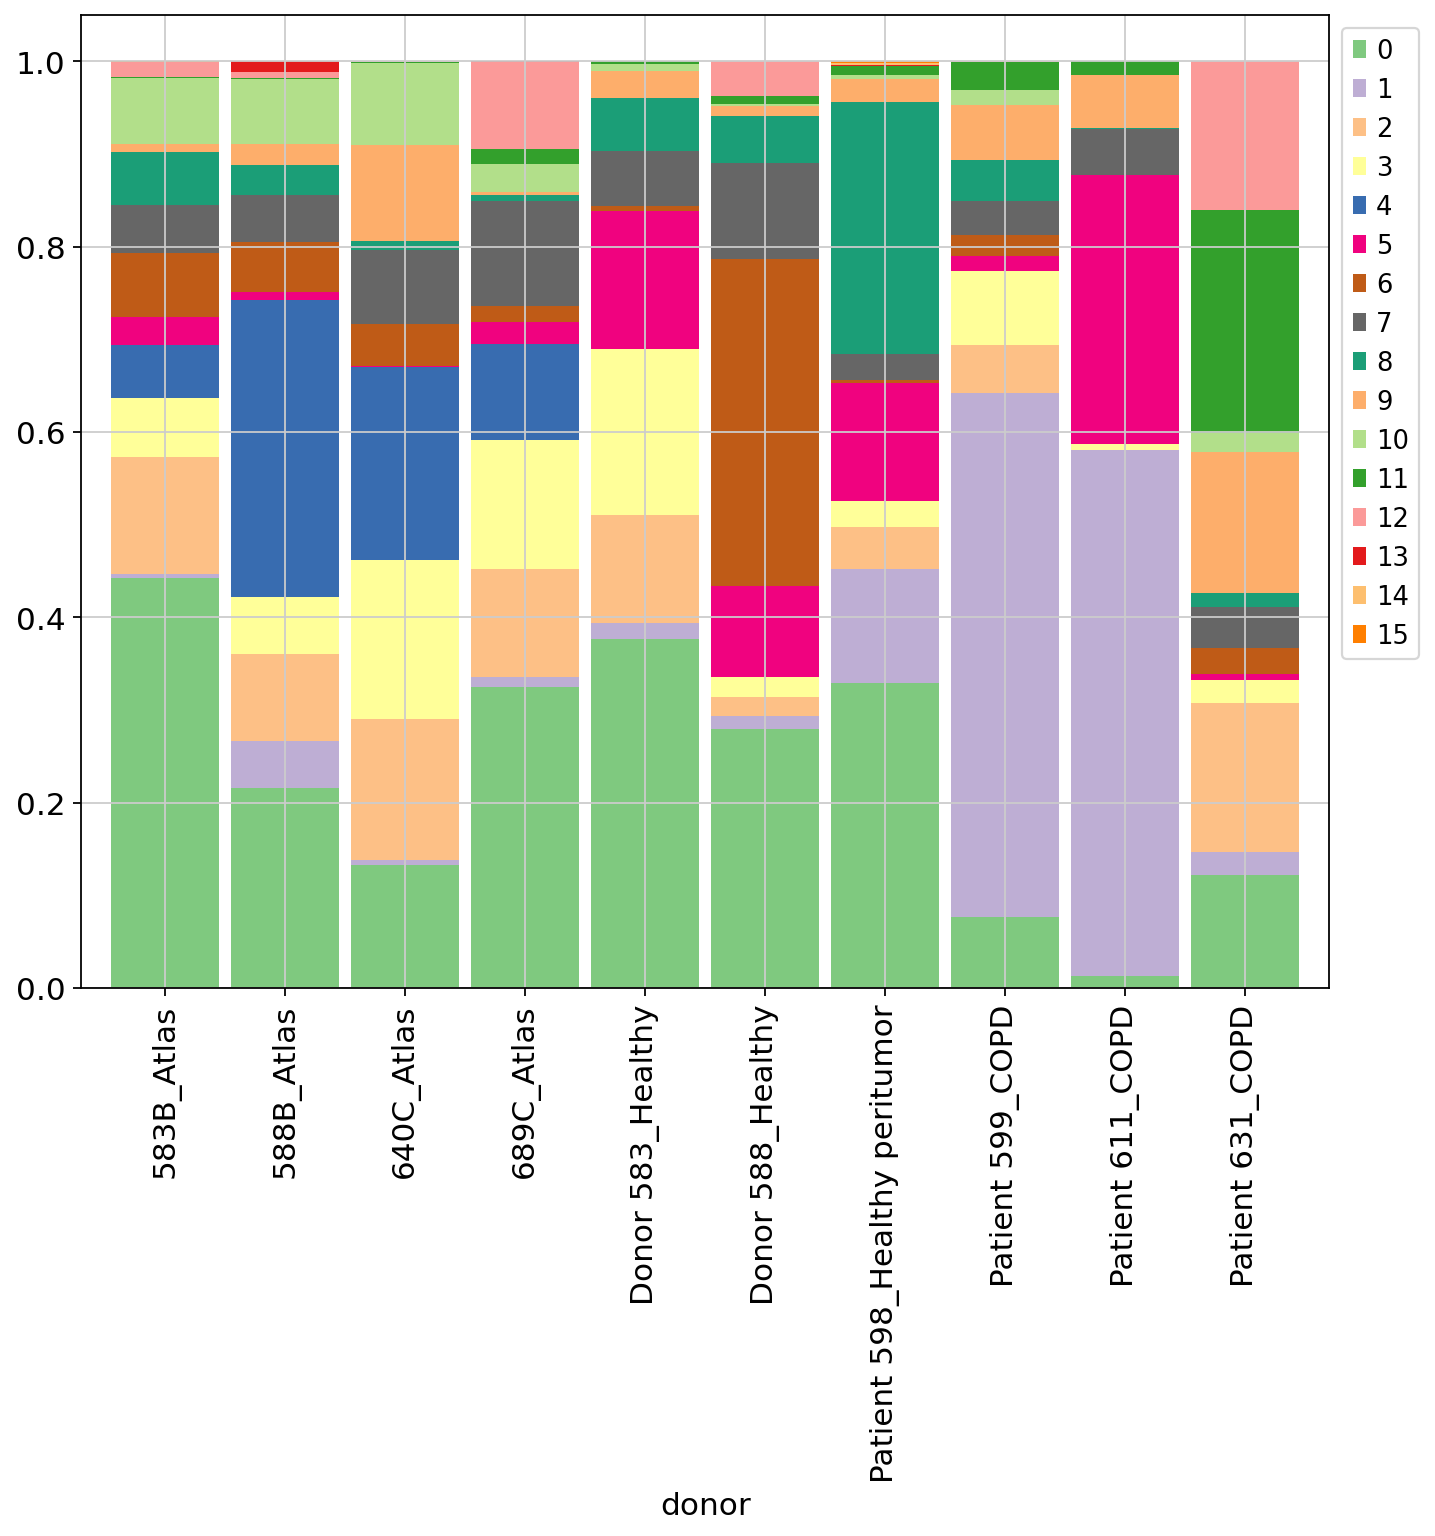

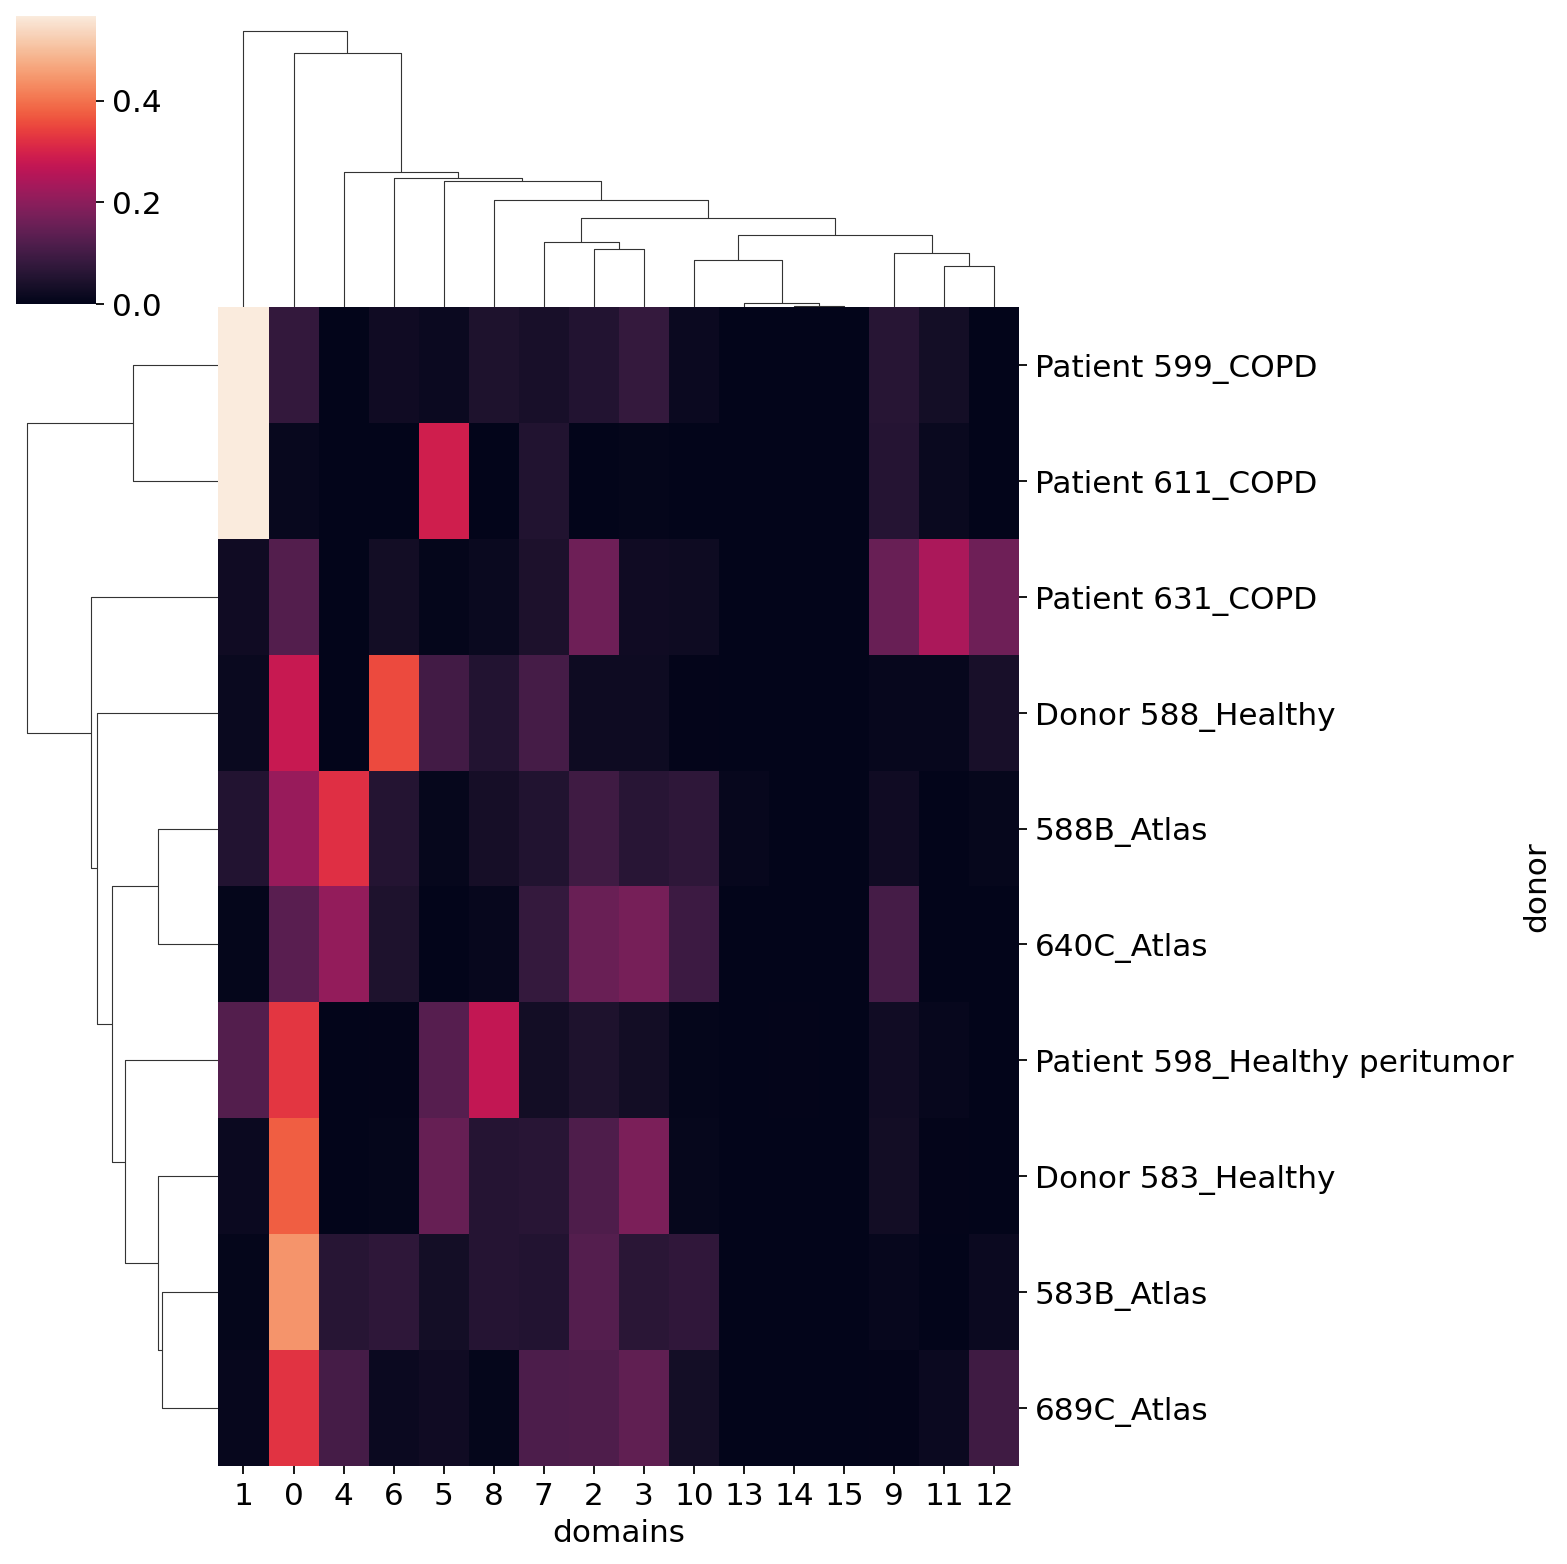

In [60]:
ctb=pd.crosstab(adataneigh.obs['donor'],adataneigh.obs['domains'])
ctb_sub=ctb.div(ctb.sum(axis=1),axis=0)
ctb_sub.index=ctb_sub.index.astype(str)+'_'+ctb_sub.index.map(d2cond)
ctb_sub.plot(kind='bar',stacked=True,width=0.9,figsize=(10,8),color=adataneigh.uns['domains_colors']).legend(
    bbox_to_anchor=(1.0, 1.0),
    fontsize='small',
)
sns.clustermap(ctb_sub,figsize=(10,10))

In [ ]:
adataneigh.obs['X']=adataneigh.obs['x']
adataneigh.obs['Y']=adataneigh.obs['y']
key='domains'
for sam in adataneigh.obs['sample'].unique():
    print(sam)
    adataneigh2=adataneigh[adataneigh.obs['sample']==sam]
    print(adataneigh2.obs['donor'][0]+'_'+str(adataneigh2.obs['condition'][0]))
    sc.set_figure_params(scanpy=True, dpi=80, dpi_save=150, frameon=True, vector_friendly=True, fontsize=14, figsize=None, color_map=None, format='pdf', facecolor='white', transparent=False, ipython_format='png2x')
    sc.pl.umap(adataneigh2,color=[key])#,save='UMAP_10X_colors.svg')
    map_of_clusters(adataneigh2,key=key,size=6,background='white',figuresize=(7,7))

In [ ]:
#plt.rcParams['plt.facecolor'] = 'white'
sc.pl.umap(adataneigh,color=['reg'],s=0.2)#,save='UMAP_10X_colors.svg')

In [ ]:
adataneigh.write('/mnt/f/COPD/niches_analysis_COPD_SCRINSHOT.h5ad')

In [2]:
import scanpy as sc
adataneigh=sc.read('/Users/sergio/Downloads/niches_analysis_COPD_SCRINSHOT_180624.h5ad')

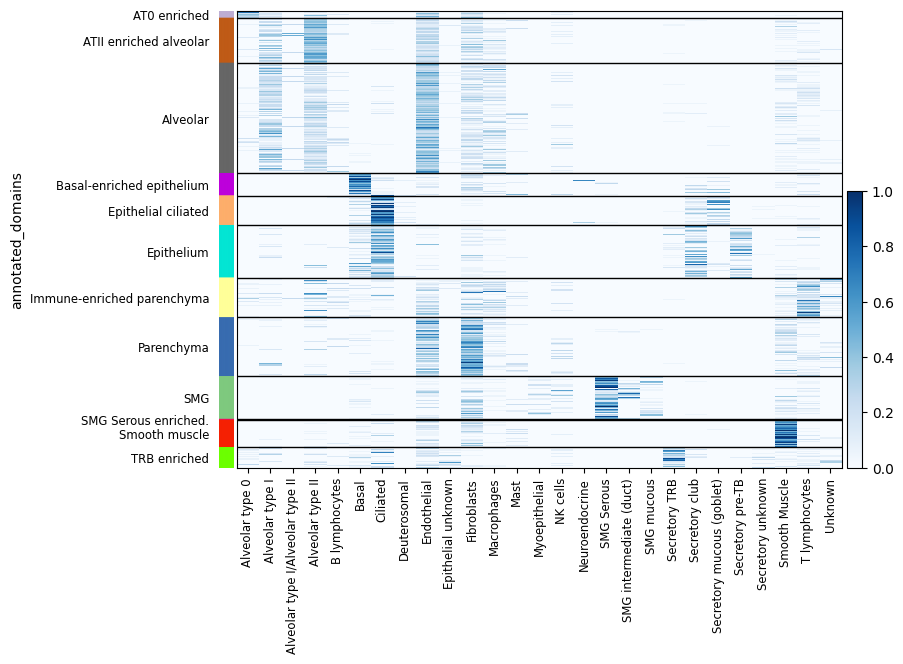

In [3]:
sc.pl.heatmap(adataneigh,adataneigh.var.index,groupby='annotated_domains',standard_scale='var',cmap='Blues')

In [10]:
composition=pd.DataFrame(adataneigh.X,columns=adataneigh.var.index)
composition['donor']=adataneigh.obs['donor']
composition['condition']=adataneigh.obs['condition']
composition['annotated_domains']=adataneigh.obs['annotated_domains']
composition['X']=adataneigh.obs['X']
composition['Y']=adataneigh.obs['Y']
composition['name']=adataneigh.obs['name']

In [11]:
composition.to_csv('/Users/sergio/Downloads/composition_niches_scrinshot_copd_5d.csv')

# plot_by_region

In [50]:
adataneigh.obs['sample_disease']=adataneigh.obs['sample'].astype(str)+'_'+adataneigh.obs['condition'].astype(str)

In [51]:
clust_by_region=pd.crosstab(adataneigh.obs['sample_disease'],adataneigh.obs['domains'])
clust_by_region=clust_by_region.div(clust_by_region.sum(axis=1),axis=0)

In [52]:
s2dis=dict(zip(adataneigh.obs['sample_disease'],adataneigh.obs['condition'].astype(str)))

In [53]:
cls=clust_by_region.unstack().reset_index()

In [54]:
cls['disease']=cls['sample_disease'].map(s2dis)

In [ ]:
plt.figure(figsize=(5,20))
sns.boxplot(data=cls,y='domains',x=0,hue='disease')

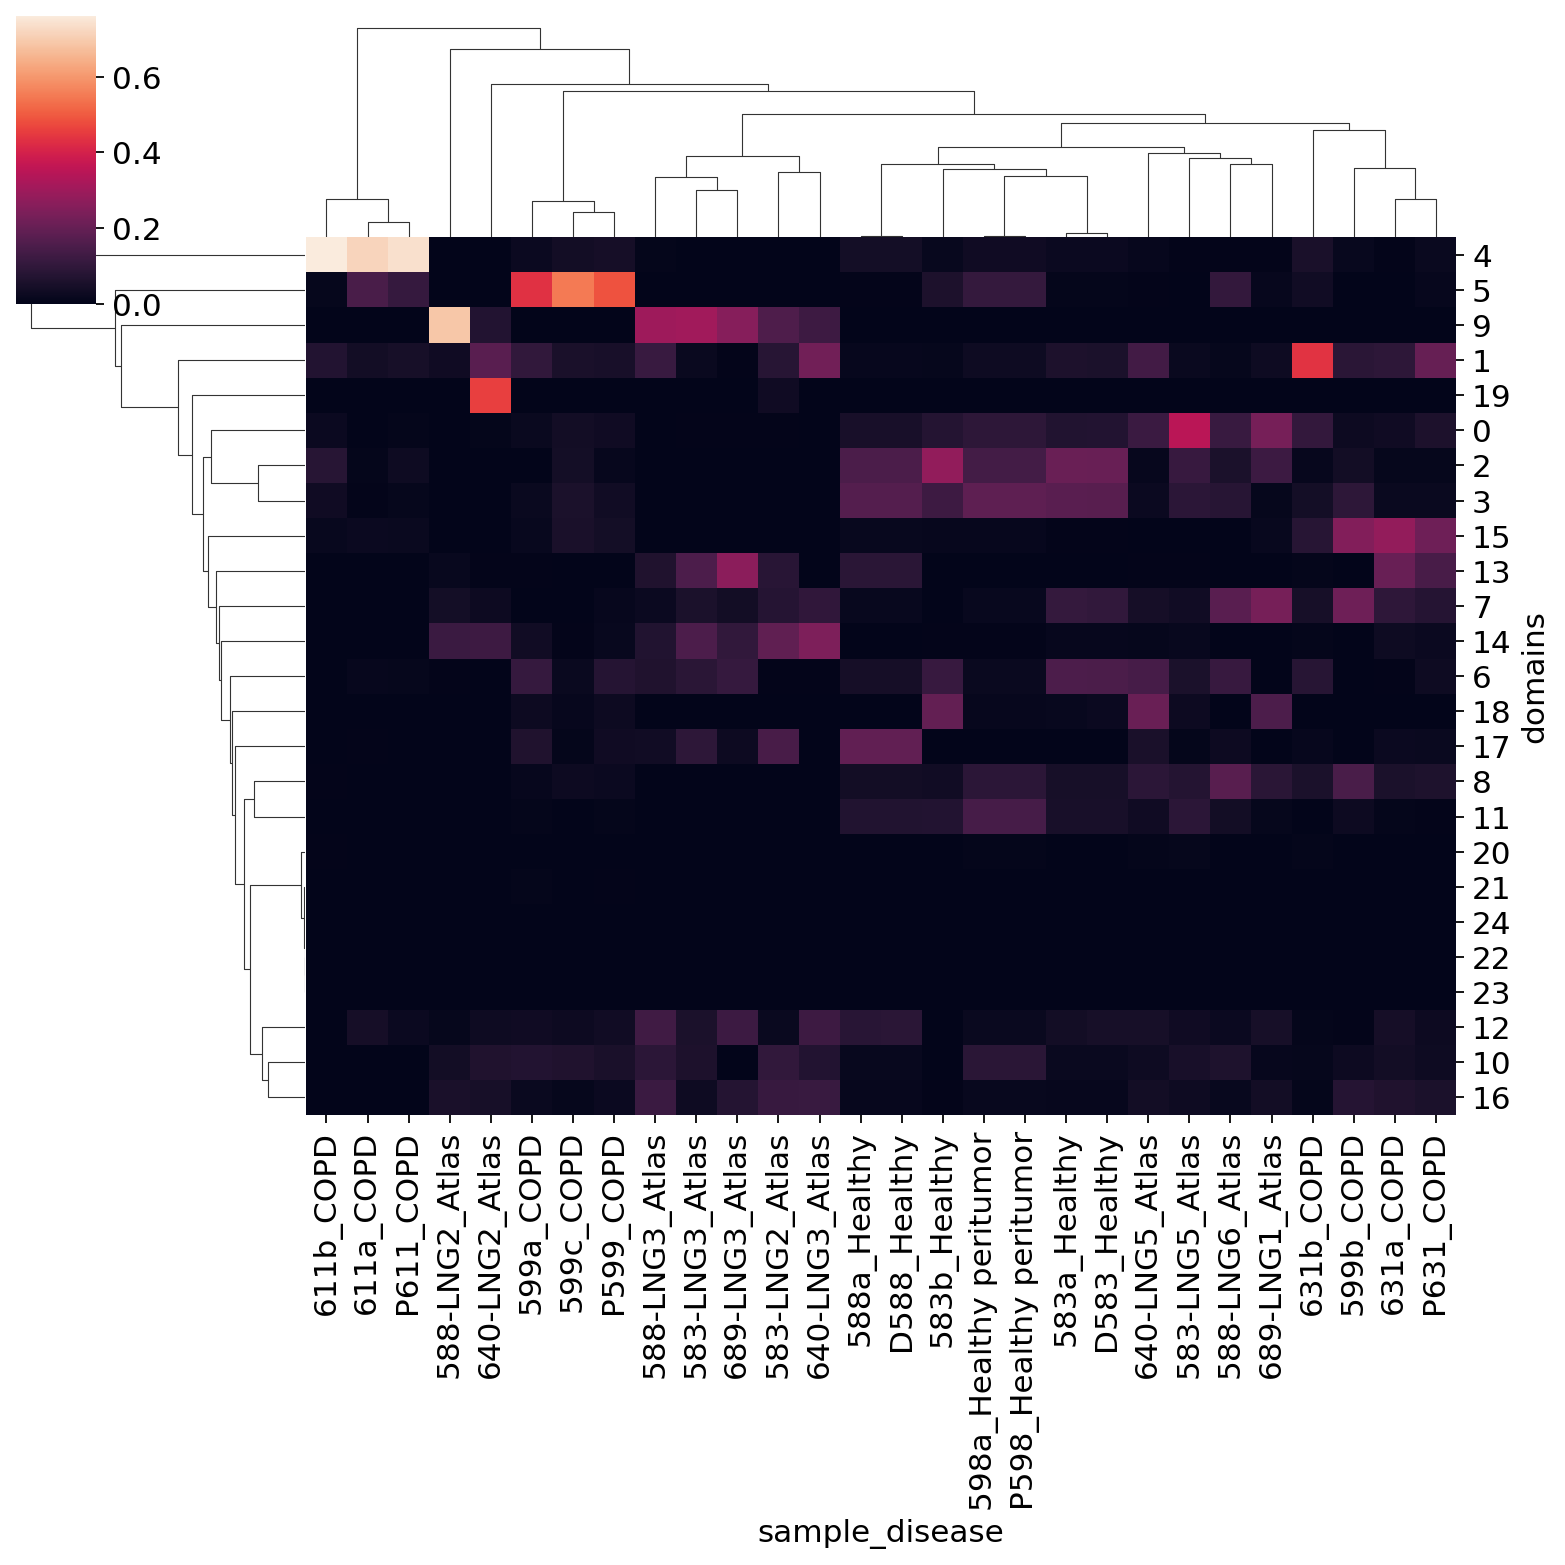

In [57]:
import seaborn as sns
sns.clustermap(clust_by_region.transpose())